# MODELING

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
import torch.optim as optim
import time

#### Add Mac acceleration

In [207]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Dataset class

In [208]:
class MultiParticipantDataset(Dataset):
    def __init__(self, df, seq_length, target_col='target', id_col='id_num', include_target_in_features=True):
        """
        df: pandas DataFrame sorted by time.
        seq_length: number of time steps in each sample.
        target_col: the column we want to predict.
        """
        df = df.drop(columns=["next_date", "categorical_target"])
        
        self.seq_length = seq_length
        self.target_col = target_col
        self.id_col = id_col
        
        df.sort_values(by=[id_col, 'date', "time_of_day"], inplace=True) if "time_of_day" in df.columns else df.sort_values(by=[id_col, 'date'])
        self.data = df.reset_index(drop=True)

        

        if include_target_in_features:
            self.features = [col for col in self.data.columns if col not in [target_col, "date"]]
        else:
            self.features = [col for col in self.data.columns if col not in [target_col, id_col, "date"]]

        # Precompute valid indices where the sequence is within the same participant.
        self.valid_indices = []
        for i in range(len(self.data) - self.seq_length):
            participant_id = self.data.iloc[i][self.id_col]
            if all(self.data.iloc[i:i+self.seq_length][self.id_col] == participant_id):
                self.valid_indices.append(i)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Use precomputed valid index.
        real_idx = self.valid_indices[idx]
        row = self.data.iloc[real_idx]
        participant_id = row[self.id_col]
        
        x_features = self.data.iloc[real_idx:real_idx+self.seq_length][self.features].values.astype(np.float32)
        x_id = np.array([participant_id]) # * self.seq_length, dtype=np.int64)
        
        # The target is the next time step's mood
        y = self.data.iloc[real_idx+self.seq_length][self.target_col]
        
        return torch.tensor(x_features),torch.tensor(x_id), torch.tensor(y).float()


### Load df

In [209]:
df = pd.read_csv("tables/imputed/df_ready_both.csv")

dataset_name = "df_interpolated"
dropped_vars = [""]
imputation = "linear interpolation"

# combine appCat cols
app_cat = [col for col in df.columns if "appCat" in col]
df["appCat"] = df[app_cat].sum(axis=1)
df.drop(columns=app_cat, inplace=True)
# df.describe()

# # get the top 15 most correlated features with the target
# numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# numerical_data = df[numerical_cols]
# corr = numerical_data.corr()
# corr_target = corr["target"]
# top_15_features = corr_target.abs().nlargest(20).index.tolist()
# # add id_num, date, and time_of_day to the top 15 features
# top_15_features = top_15_features + ["id_num", "date", "time_of_day"]
# df = df[top_15_features]
# print(f"Top 15 features correlated with target: {top_15_features}")


### Train test split

In [210]:
dfs_train = []
dfs_test = []
proportion_train = 0.8
seq_length = 5

for participant, group in df.groupby('id_num'):
    group = group.sort_values(by='date')
    # Calculate the split index based on the proportion
    split_idx = int(len(group) * proportion_train)
    # Ensure that the test set has at least seq_length + 1 samples
    if len(group) - split_idx < seq_length + 1:
        # Adjust the split index accordingly
        split_idx = len(group) - (seq_length + 1)
    if split_idx <= 0:
        # Option: Skip this participant if not enough data
        continue
    dfs_train.append(group.iloc[:split_idx])
    dfs_test.append(group.iloc[split_idx:])

train_df = pd.concat(dfs_train)
test_df = pd.concat(dfs_test)

# SPLIT ACROSS PARTICIPANTS

# # Extract unique participant IDs
# participant_ids = df['id_num'].unique()

# # Split participants (e.g., 80% train, 20% test)
# train_ids, test_ids = train_test_split(participant_ids, test_size=0.2, random_state=42)
# print(f"Train IDs: {train_ids}")
# print(f"Test IDs: {test_ids}")

# # Filter the original DataFrame based on these IDs
# train_df = df[df['id_num'].isin(train_ids)].copy()
# test_df = df[df['id_num'].isin(test_ids)].copy()

# # Optional: sort your data by participant and day if not already sorted
# train_df.sort_values(by=['id_num', 'day'], inplace=True)
# test_df.sort_values(by=['id_num', 'day'], inplace=True)


# get mood descriptives
print("Train mood descriptives")
print(train_df["target"].describe())
print("Test mood descriptives")
print(test_df["target"].describe())

# get the start end end dates per participant per df
train_start_dates = train_df.groupby('id_num')['date'].min()
train_end_dates = train_df.groupby('id_num')['date'].max()
test_start_dates = test_df.groupby('id_num')['date'].min()
test_end_dates = test_df.groupby('id_num')['date'].max()




# put in a dataframe with participant train start end and test start end
dates_df = pd.DataFrame({
    "participant": train_start_dates.index,
    "train_start": train_start_dates.values,
    "train_end": train_end_dates.values,
    "test_start": test_start_dates.values,
    "test_end": test_end_dates.values,
})

dates_df.to_csv("tables/training_dates_split.csv", index=False)


Train mood descriptives
count    3036.000000
mean        6.991757
std         0.728714
min         3.000000
25%         6.600000
50%         7.000000
75%         7.500000
max         9.333333
Name: target, dtype: float64
Test mood descriptives
count    771.000000
mean       7.011835
std        0.727952
min        4.800000
25%        6.666667
50%        7.000000
75%        7.500000
max        9.000000
Name: target, dtype: float64


### Normalize

In [211]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

def normalize_per_participant(df, scaler_dict=None, scaler_target_dict=None, transform_target=False, scaler_type="StandardScaler", fit=True):
    df = df.copy()
    features = [col for col in df.columns if col not in ['id_num', "date", "target", "next_date"]]
    
    df_list = []
    new_scaler_dict = {} if scaler_dict is None else scaler_dict.copy()
    new_scaler_target_dict = {} if scaler_target_dict is None else scaler_target_dict.copy()

    for pid, group in df.groupby("id_num"):
        group = group.copy()
        
        # Use existing or new scaler
        if pid not in new_scaler_dict and fit:
            scaler = StandardScaler() if scaler_type == "StandardScaler" else MinMaxScaler()
            new_scaler_dict[pid] = scaler.fit(group[features])
        scaler = new_scaler_dict[pid]
        group[features] = scaler.transform(group[features])
        
        # Optionally transform target
        if transform_target:
            if pid not in new_scaler_target_dict and fit:
                scaler_target = StandardScaler() if scaler_type == "StandardScaler" else MinMaxScaler()
                # scaler_target = StandardScaler()
                new_scaler_target_dict[pid] = scaler_target.fit(group[["target"]])
            scaler_target = new_scaler_target_dict[pid]
            group["target"] = scaler_target.transform(group[["target"]])
        
        df_list.append(group)

    return pd.concat(df_list, ignore_index=True), new_scaler_dict, new_scaler_target_dict

# def denormalize(df, scaler, scaler_target=None):

#     features = [col for col in df.columns if col not in ['id_num', 'day', "date", "next_day_mood", "next_day", "mood"]]
    
#     # Inverse transform the features
#     df[features] = scaler.inverse_transform(df[features])
    
#     if scaler_target is not None:
#         # Inverse transform the target column "mood"
#         df["mood"] = scaler_target.inverse_transform(df[["mood"]])
    
    # return df

TRANSFORM_TARGET = True
SCALER_TYPE = "MinMaxScaler"
# SCALER_TYPE = "StandardScaler"
# Normalize the training and test data
train_df_normalized, scaler, scaler_target = normalize_per_participant(train_df, transform_target=TRANSFORM_TARGET, scaler_type=SCALER_TYPE)
test_df_normalized, _, _ = normalize_per_participant(test_df, scaler_dict=scaler, scaler_target_dict=scaler_target, fit=False, transform_target=TRANSFORM_TARGET, scaler_type=SCALER_TYPE)

print(f"Train shape: {train_df_normalized.shape}, Test shape: {test_df_normalized.shape}") # Train shape: (1230, 24), Test shape: (307, 24)



Train shape: (3036, 102), Test shape: (771, 102)


### Create dataset

In [212]:

# Create the dataset
seq_length = 5
batch_size = 256


train_dataset = MultiParticipantDataset(train_df_normalized, seq_length=seq_length)
test_dataset = MultiParticipantDataset(test_df_normalized, seq_length=seq_length)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shape of the data
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")
for x, x_id, y in train_loader:
    print(f"x shape: {x.shape}, x_id shape: {x_id.shape}, y shape: {y.shape}")
    break
# 32 sequences in a batch, each with 5 time steps and 24 features


Number of batches in train_loader: 12
Number of batches in test_loader: 3
x shape: torch.Size([256, 5, 98]), x_id shape: torch.Size([256, 1]), y shape: torch.Size([256])


### define lstm model

In [213]:

class LSTMModel(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int = 64,
                 num_layers: int = 2,
                 output_dim: int = 1,
                 dropout: float = 0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor, lengths: torch.LongTensor = None):
        """
        x:      (batch_size, seq_len, input_dim)
        lengths:(batch_size,) actual lengths (no need to sort if enforce_sorted=False)
        """
        batch_size = x.size(0)
        device = x.device

        # init h0, c0 on the right device
        h0 = torch.zeros(self.num_layers,
                         batch_size,
                         self.hidden_dim,
                         device=device)
        c0 = torch.zeros_like(h0)

        if lengths is not None:
            packed = pack_padded_sequence(x,
                                          lengths.cpu(),
                                          batch_first=True,
                                          enforce_sorted=False)
            packed_out, _ = self.lstm(packed, (h0, c0))
            out, _ = pad_packed_sequence(packed_out, batch_first=True)
            # grab the last valid output for each batch
            idx = lengths - 1  # shape: (batch_size,)
            last = out[torch.arange(batch_size, device=device), idx]
        else:
            out, _ = self.lstm(x, (h0, c0))
            last = out[:, -1, :]

        return self.fc(last)



class GRUModel(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int = 64,
                 num_layers: int = 2,
                 output_dim: int = 1,
                 dropout: float = 0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.res_fc = nn.Linear(input_dim, output_dim)


        self.gru = nn.GRU(input_dim,
                          hidden_dim,
                          num_layers,
                          batch_first=True,
                          dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x: torch.Tensor, lengths: torch.LongTensor = None):
        batch_size = x.size(0)
        device = x.device

        # init h0
        h0 = torch.randn(self.num_layers,
                         batch_size,
                         self.hidden_dim,
                         device=device)

        if lengths is not None:
            packed = pack_padded_sequence(x,
                                          lengths.cpu(),
                                          batch_first=True,
                                          enforce_sorted=False)
            packed_out, _ = self.gru(packed, h0)
            out, _ = pad_packed_sequence(packed_out, batch_first=True)
            idx = lengths - 1
            last = out[torch.arange(batch_size, device=device), idx]
        else:
            out, _ = self.gru(x, h0)
            last = out[:, -1, :]

        return self.fc(last) + self.res_fc(x[:, -1, :])  # self.fc(last)



class SimpleRNNModel(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int = 64,
                 num_layers: int = 2,
                 output_dim: int = 1,
                 dropout: float = 0.2,
                 noisy_init: bool = False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.noisy_init = noisy_init

        self.rnn = nn.RNN(input_dim,
                          hidden_dim,
                          num_layers,
                          batch_first=True,
                          dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor, lengths: torch.LongTensor = None):
        batch_size = x.size(0)
        device = x.device

        # choose zero- or small‑noisy initial state
        if self.noisy_init:
            h0 = torch.randn(self.num_layers,
                             batch_size,
                             self.hidden_dim,
                             device=device) * 0.01
        else:
            h0 = torch.zeros(self.num_layers,
                             batch_size,
                             self.hidden_dim,
                             device=device)

        if lengths is not None:
            packed = pack_padded_sequence(x,
                                          lengths.cpu(),
                                          batch_first=True,
                                          enforce_sorted=False)
            packed_out, _ = self.rnn(packed, h0)
            out, _ = pad_packed_sequence(packed_out, batch_first=True)
            idx = lengths - 1
            last = out[torch.arange(batch_size, device=device), idx]
        else:
            out, _ = self.rnn(x, h0)
            last = out[:, -1, :]

        return self.fc(last)

### Train loop

Using device: mps
Epoch [1/20], Train Loss: 0.5436, Eval Loss: 0.4154
Epoch [2/20], Train Loss: 0.2252, Eval Loss: 0.2284
Epoch [3/20], Train Loss: 0.1415, Eval Loss: 0.1741
Epoch [4/20], Train Loss: 0.1108, Eval Loss: 0.1515
Epoch [5/20], Train Loss: 0.0946, Eval Loss: 0.1297
Epoch [6/20], Train Loss: 0.0849, Eval Loss: 0.1207
Epoch [7/20], Train Loss: 0.0799, Eval Loss: 0.1085
Epoch [8/20], Train Loss: 0.0757, Eval Loss: 0.1043
Epoch [9/20], Train Loss: 0.0720, Eval Loss: 0.0955
Epoch [10/20], Train Loss: 0.0680, Eval Loss: 0.0929
Epoch [11/20], Train Loss: 0.0669, Eval Loss: 0.0905
Epoch [12/20], Train Loss: 0.0646, Eval Loss: 0.0883
Epoch [13/20], Train Loss: 0.0640, Eval Loss: 0.0904
Epoch [14/20], Train Loss: 0.0630, Eval Loss: 0.0863
Epoch [15/20], Train Loss: 0.0615, Eval Loss: 0.0839
Epoch [16/20], Train Loss: 0.0606, Eval Loss: 0.0846
Epoch [17/20], Train Loss: 0.0592, Eval Loss: 0.0853
Epoch [18/20], Train Loss: 0.0587, Eval Loss: 0.0828
Epoch [19/20], Train Loss: 0.0581, Ev

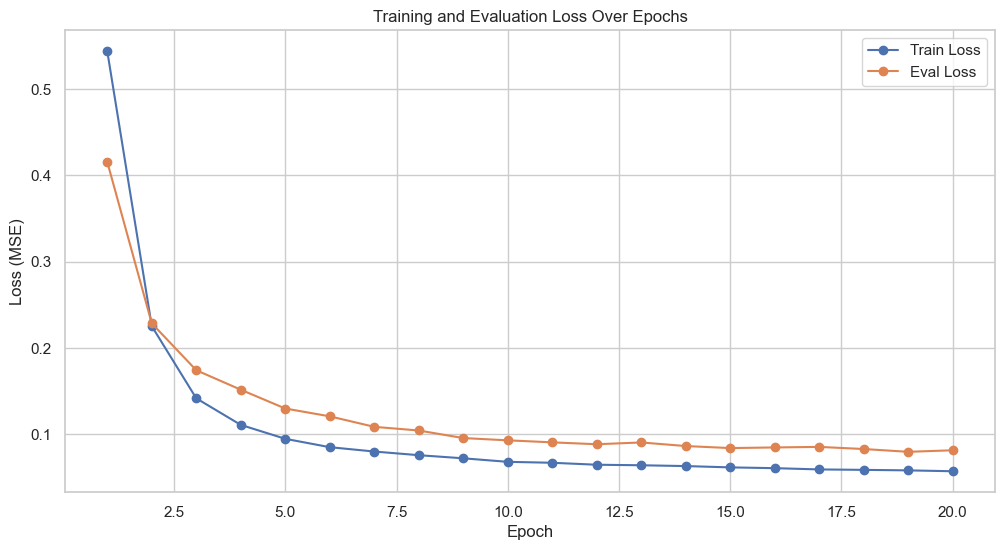

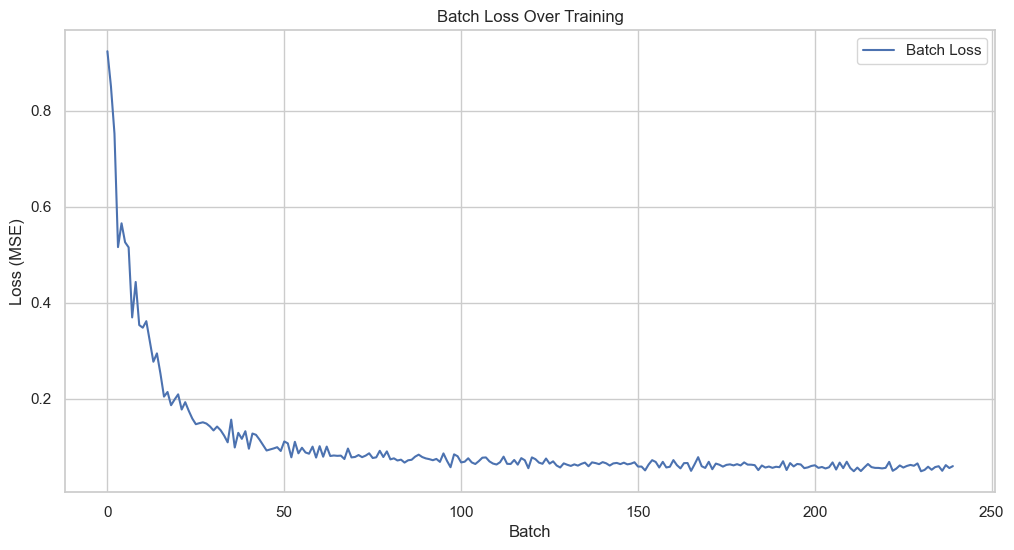

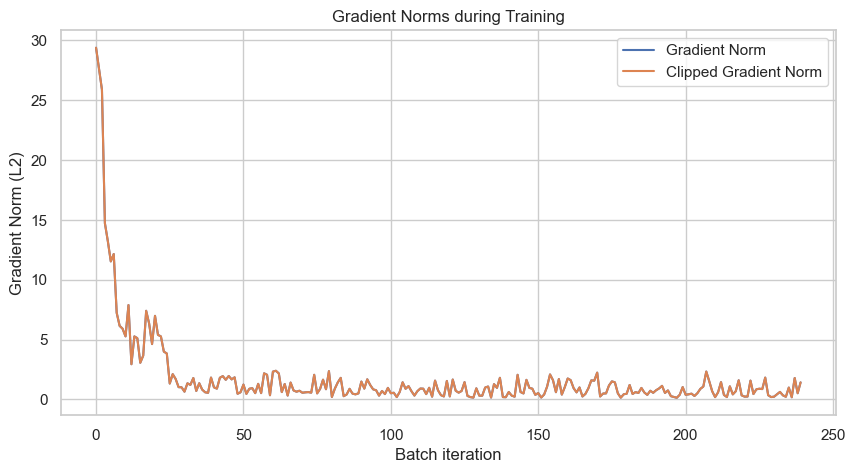

In [221]:
# Hyperparameters

def train(config, train_loader, test_loader):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
    else:
        mps_device = torch.device("cpu")
    print(f"Using device: {mps_device}")

    # Initialize model, loss function, and optimizer
    # model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
    input_dim = config["input_dim"]
    hidden_dim = config["hidden_dim"]
    num_layers = config["num_layers"]
    output_dim = config["output_dim"]
    dropout = config["dropout"]
    num_epochs = config["num_epochs"]
    learning_rate = config["learning_rate"]
    model_type = config["model"]

    if model_type == "LSTM":
        model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout)
    elif model_type == "RNN":
        model = SimpleRNNModel(input_dim, hidden_dim, num_layers, output_dim, dropout)
    elif model_type == "GRU":
        model = GRUModel(input_dim, hidden_dim, num_layers, output_dim, dropout)

    model = model.to(mps_device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=1e-5)

    # Prepare lists to store loss values for plotting
    train_epoch_losses = []
    eval_epoch_losses = []
    batch_losses = []
    grad_norms = []  # list to store gradient norms for each batch
    clipped_grad_norms = []  # list to store clipped gradient norms for each batch


    # Training and evaluation loop
    for epoch in range(num_epochs):
        model.train()
        train_loss_epoch = 0.0

        # --- Training ---
        for batch in train_loader:
            x_features, x_id, y = batch  # x_features: [batch, seq_length, input_dim]
            x_features = x_features.to(mps_device)
            x_id = x_id.to(mps_device)
            y = y.to(mps_device)  # y: [batch, output_dim]
            
            # Forward pass
            outputs = model(x_features)  # outputs shape: [batch, output_dim]
            loss = criterion(outputs.squeeze(), y)

            batch_losses.append(loss.item())
            
            # Backprop and optimization
            optimizer.zero_grad()
            loss.backward()

            # Compute total gradient norm
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            grad_norms.append(total_norm)
            # Clip gradients
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # or another max_norm value

            # Compute clipped gradient norm
            clipped_grad_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    clipped_grad_norm += param_norm.item() ** 2
            clipped_grad_norm = clipped_grad_norm ** 0.5
            clipped_grad_norms.append(clipped_grad_norm)

            optimizer.step()
            
            train_loss_epoch += loss.item()
        
        avg_train_loss = train_loss_epoch / len(train_loader)
        train_epoch_losses.append(avg_train_loss)
        
        # --- Evaluation ---
        model.eval()
        eval_loss_epoch = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x_features, x_id, y = batch
                x_features = x_features.to(mps_device)
                x_id = x_id.to(mps_device)
                y = y.to(mps_device)
                outputs = model(x_features)
                loss = criterion(outputs.squeeze(), y)
                eval_loss_epoch += loss.item()
        
        avg_eval_loss = eval_loss_epoch / len(test_loader)
        eval_epoch_losses.append(avg_eval_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")

    # Plot the training and evaluation loss curves
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs+1), train_epoch_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs+1), eval_epoch_losses, label='Eval Loss', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Evaluation Loss Over Epochs")
    plt.legend()
    plt.show()

    # plot batch losses
    plt.figure(figsize=(12, 6))
    plt.plot(batch_losses, label='Batch Loss')
    plt.xlabel("Batch")
    plt.ylabel("Loss (MSE)")
    plt.title("Batch Loss Over Training")
    plt.legend()
    plt.show()

    # plot gradient norms
    plt.figure(figsize=(10, 5))
    plt.plot(grad_norms)
    plt.plot(clipped_grad_norms)
    plt.legend(["Gradient Norm", "Clipped Gradient Norm"])
    plt.xlabel("Batch iteration")
    plt.ylabel("Gradient Norm (L2)")
    plt.title("Gradient Norms during Training")
    plt.show()

    return model, train_epoch_losses, eval_epoch_losses, batch_losses, grad_norms, clipped_grad_norms



config = {
    "input_dim": len(train_dataset.features),
    "hidden_dim": 16,
    "num_layers": 1,
    "output_dim": 1,
    "num_epochs": 20,
    "learning_rate": 0.001,
    "dropout": 0,
    "model": "GRU",
}

model, train_epoch_losses, eval_epoch_losses, batch_losses, grad_norms, clipped_grad_norms = train(config, train_loader, test_loader)


# # append the csv with hyperparameters and losses
# hyperparameters = {
#     "dataset": dataset_name,
#     "dropped_vars": dropped_vars,
#     "imputation": imputation,
#     "model": "GRU",
#     "sequence_length": seq_length,
#     "scaler": SCALER_TYPE,
#     "scaler_target": TRANSFORM_TARGET,
#     "batch_size": batch_size,
#     "input_dim": input_dim,
#     "hidden_dim": hidden_dim,
#     "num_layers": num_layers,
#     "output_dim": output_dim,
#     "dropout": dropout,
#     "num_epochs": num_epochs,
#     "learning_rate": learning_rate,
#     "train_loss": train_epoch_losses[-1],
#     "eval_loss": eval_epoch_losses[-1],
#     "Features": train_dataset.features,
#     "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
# }
# print(hyperparameters)
# hyperparameters_df = pd.DataFrame([hyperparameters])
# if not os.path.exists("tables/hyperparameters2.csv"):
#     # create the csv with the hyperparameters
#     hyperparameters_df.to_csv("tables/hyperparameters2.csv", index=False, header=True)
# hyperparameters_df = pd.DataFrame([hyperparameters])
# hyperparameters_df.to_csv("tables/hyperparameters2.csv", mode='a', header=False, index=False)


### Predict and plot function

Predictions shape: (2927, 1), Targets shape: (2927, 1), Participant IDs shape: (2927, 1)
Predictions shape: (662, 1), Targets shape: (662, 1), Participant IDs shape: (662, 1)

Train Descriptive Statistics:
Predictions - Mean: 6.95, Std: 0.49, Min: 4.63, Max: 8.55
Targets     - Mean: 6.99, Std: 0.73, Min: 3.00, Max: 9.33
Train MAE: 0.477, MSE: 0.402, R2: 0.254

Test Descriptive Statistics:
Predictions - Mean: 6.95, Std: 0.49, Min: 5.19, Max: 8.03
Targets     - Mean: 7.01, Std: 0.77, Min: 3.44, Max: 9.00
Test MAE: 0.541, MSE: 0.522, R2: 0.111
n data points in targets: 23
n data points in predictions: 23

Participant 1 Descriptive Statistics:
Predictions - Mean: 7.13, Std: 0.16, Min: 6.86, Max: 7.49
Targets     - Mean: 7.68, Std: 0.35, Min: 7.00, Max: 8.00
Participant 1 MAE: 0.579, MSE: 0.432, R2: -2.569


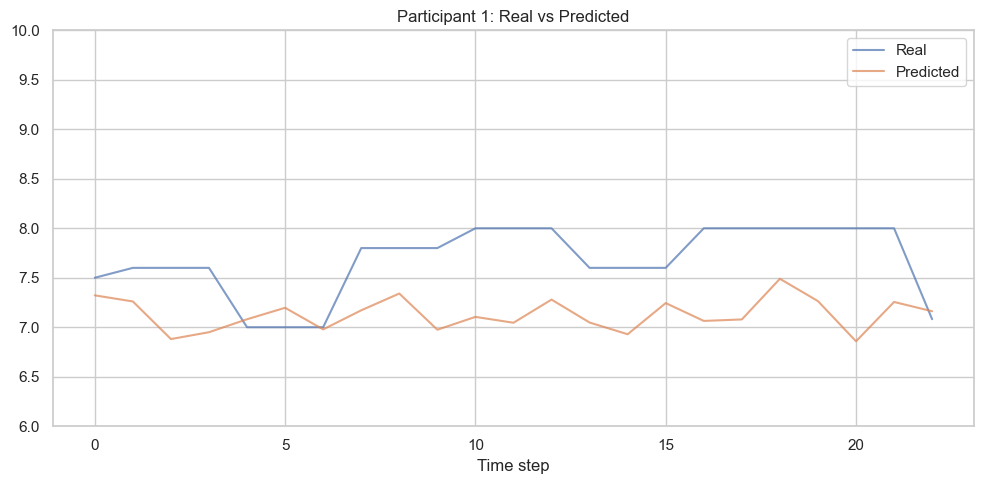

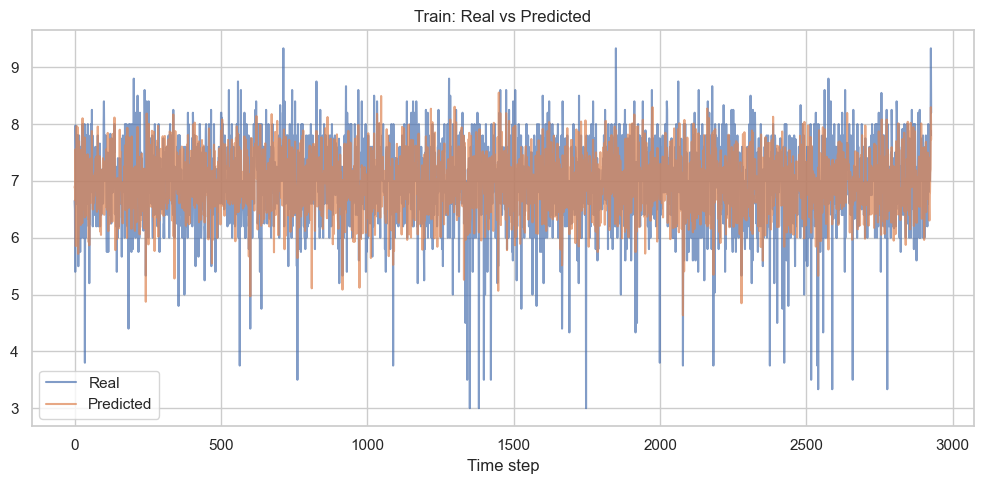

<Figure size 640x480 with 0 Axes>

/var/folders/f9/4f7hqdfs2fjbhkvbpghqwvd00000gn/T/ipykernel_17079/696055431.py:149: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


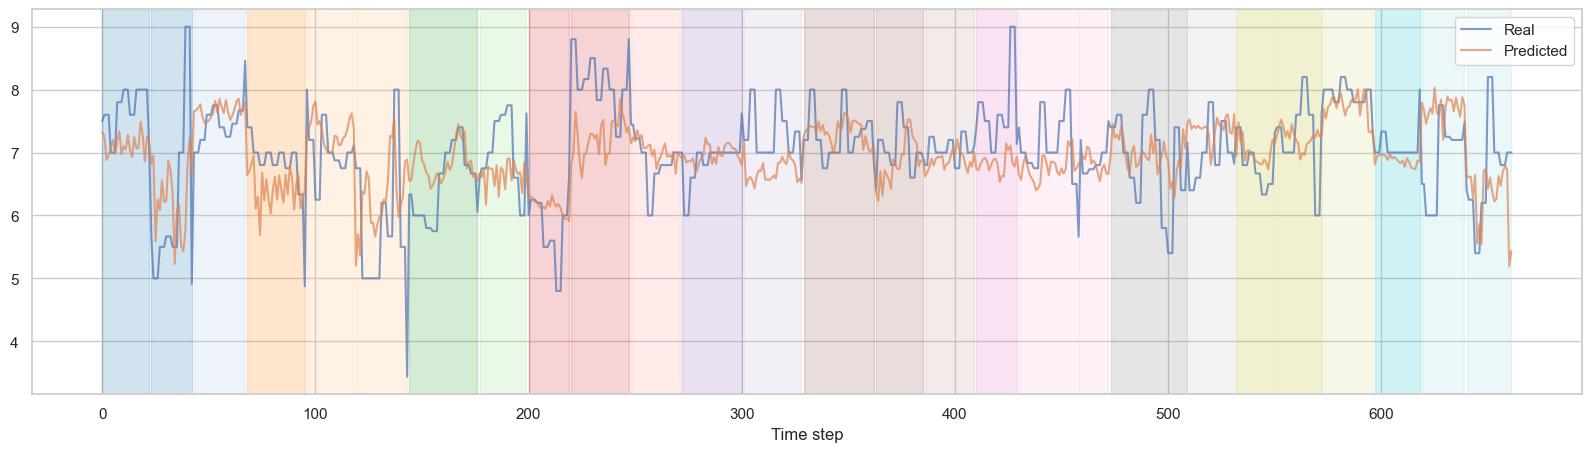

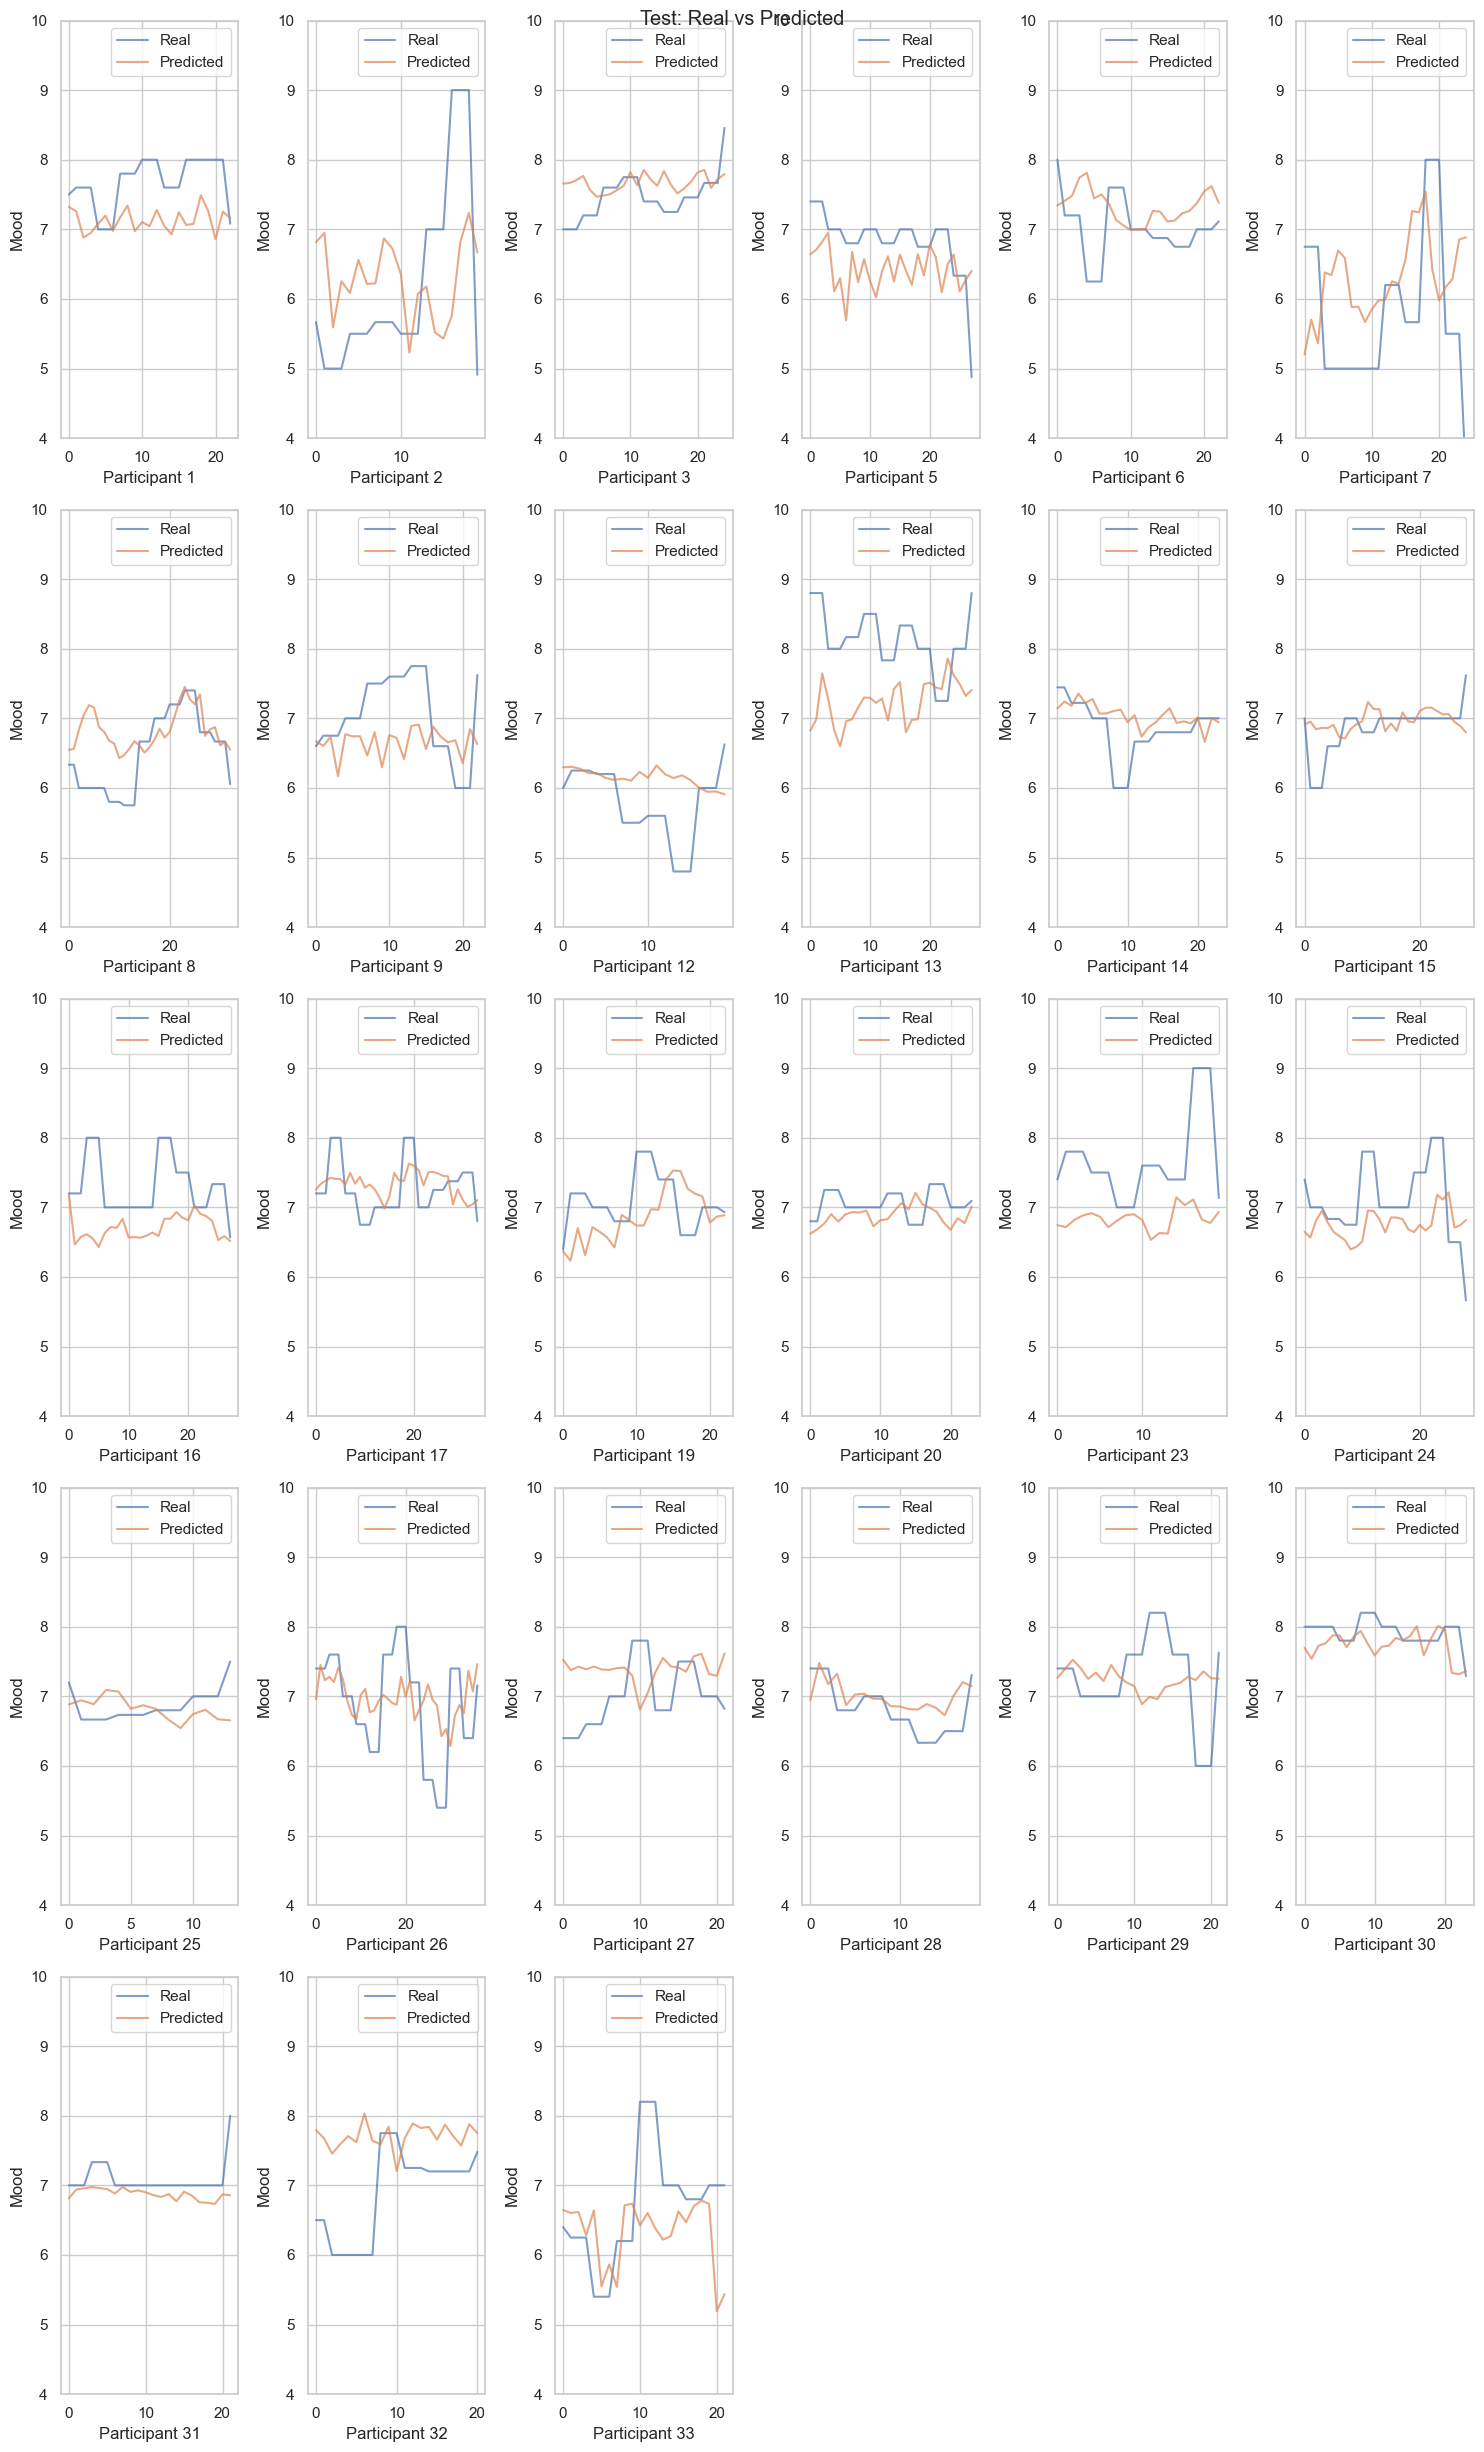

In [222]:
def predict_and_plot_simple(model, train_loader, test_loader, target_scaler=None, participant=None):
    def get_predictions(loader):
        model.eval()
        predictions = []
        targets = []
        participant_ids = []
        with torch.no_grad():
            for batch in loader:
                # Assuming your batch structure is (x, x_id, y)
                x, x_id, y = batch  
                x = x.cpu()
                y = y.cpu()
                # Convert x_id to CPU and then to numpy if needed for masking
                x_id = x_id.cpu().numpy()
                output = model(x)
                predictions.append(output.cpu().numpy())  # Ensure output is on CPU
                targets.append(y.cpu().numpy())
                participant_ids.append(x_id)  # Collect participant IDs

        predictions = np.concatenate(predictions).reshape(-1, 1)
        targets = np.concatenate(targets).reshape(-1, 1)
        participant_ids = np.concatenate(participant_ids).reshape(-1, 1)
    
        print(f"Predictions shape: {predictions.shape}, Targets shape: {targets.shape}, Participant IDs shape: {participant_ids.shape}")
        # print(predictions)
        # print(targets)
        # print(participant_ids)

        if target_scaler is not None:
            # Loop through each participant and apply the respective inverse scaler
            for participant, scaler in target_scaler.items():
                # Create a boolean mask based on participant id (participant_ids is shape (n, 1))
                mask = (participant_ids == participant)
                # For predictions: reshape the 1D selection to 2D for the scaler, then flatten the result for assignment.
                temp_pred = scaler.inverse_transform(predictions[mask].reshape(-1, 1))
                predictions[mask] = temp_pred.ravel()
                # Do the same for targets:
                temp_tgt = scaler.inverse_transform(targets[mask].reshape(-1, 1))
                targets[mask] = temp_tgt.ravel()
            
        return predictions.reshape(-1), targets.reshape(-1), participant_ids.reshape(-1)

    model.to("cpu")

    y_pred_train, y_true_train, participant_ids = get_predictions(train_loader)
    y_pred_test, y_true_test, participant_ids = get_predictions(test_loader)

    def print_stats(y_true, y_pred, label=""):
        print(f"\n{label} Descriptive Statistics:")
        print(f"Predictions - Mean: {np.mean(y_pred):.2f}, Std: {np.std(y_pred):.2f}, Min: {np.min(y_pred):.2f}, Max: {np.max(y_pred):.2f}")
        print(f"Targets     - Mean: {np.mean(y_true):.2f}, Std: {np.std(y_true):.2f}, Min: {np.min(y_true):.2f}, Max: {np.max(y_true):.2f}")
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"{label} MAE: {mae:.3f}, MSE: {mse:.3f}, R2: {r2:.3f}")
        return mae, mse, r2

    # Print metrics
    print_stats(y_true_train, y_pred_train, "Train")
    print_stats(y_true_test, y_pred_test, "Test")

    # select a specific participant
    if participant is not None:
        mask = (participant_ids == participant)
        y_pred_participant = y_pred_test[mask]
        y_true_participant = y_true_test[mask]
        print("n data points in targets:", len(y_true_participant))
        print("n data points in predictions:", len(y_pred_participant))
        print_stats(y_true_participant, y_pred_participant, f"Participant {participant}")
        # Plot for a specific participant
        plt.figure(figsize=(10, 5))
        plt.plot(y_true_participant, label="Real", alpha=0.7)
        plt.plot(y_pred_participant, label="Predicted", alpha=0.7)
        plt.title(f"Participant {participant}: Real vs Predicted")
        plt.legend()
        plt.xlabel("Time step")
        plt.ylim(6,10)
        plt.tight_layout()
        plt.show()

    # Plot results for training data
    plt.figure(figsize=(10, 5))
    plt.plot(y_true_train, label="Real", alpha=0.7)
    plt.plot(y_pred_train, label="Predicted", alpha=0.7)
    plt.title("Train: Real vs Predicted")
    plt.legend()
    plt.xlabel("Time step")
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

    # Plot results for testing data
    fig, ax1 = plt.subplots(figsize=(20, 5))
    

    

    
    # Separate test plotting by participant
    import math

    unique_participants = np.unique(participant_ids)
    n_parts = len(unique_participants)
    # Determine grid size (roughly square)
    n_cols = math.ceil(math.sqrt(n_parts))
    n_rows = math.ceil(n_parts / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), squeeze=False)
    axes = axes.flatten()  # flatten to easily index each subplot

    change_idx = []
    # create color map of length n unique participants
    cmap = plt.get_cmap("tab20", n_parts)

    for idx, part in enumerate(unique_participants):
        mask = (participant_ids == part)
        participant_idxs = np.where(mask)[0]
        start_line = participant_idxs[0]
        end_line = participant_idxs[-1]
        y_true_part = y_true_test[mask]
        y_pred_part = y_pred_test[mask]

        
        ax = axes[idx]
        ax.plot(y_true_part, label="Real", alpha=0.7)
        ax.plot(y_pred_part, label="Predicted", alpha=0.7)

        ax1.axvspan(start_line, end_line, color=cmap(idx) , alpha=0.2)
        # ax.set_title(f"Real vs Predicted")
        ax.set_xlabel(f"Participant {part}")
        ax.set_ylabel("Mood")
        ax.legend()
        ax.set_ylim(4, 10)
        ax.grid(True)

    # Turn off any unused subplots.
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')


    ax1.plot(y_true_test, label="Real", alpha=0.7)
    ax1.plot(y_pred_test, label="Predicted", alpha=0.7)
    fig.suptitle("Test: Real vs Predicted")
    ax1.set_xlabel("Time step")
    ax1.legend()
    fig.tight_layout()
    fig.show()
    

predict_and_plot_simple(model, train_loader, test_loader, target_scaler=scaler_target, participant=1)

Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'GRU'}
Using device: mps
Epoch [1/10], Train Loss: 0.1703, Eval Loss: 0.1774
Epoch [2/10], Train Loss: 0.1267, Eval Loss: 0.1393
Epoch [3/10], Train Loss: 0.1046, Eval Loss: 0.1209
Epoch [4/10], Train Loss: 0.0873, Eval Loss: 0.0986
Epoch [5/10], Train Loss: 0.0720, Eval Loss: 0.0882
Epoch [6/10], Train Loss: 0.0648, Eval Loss: 0.0818
Epoch [7/10], Train Loss: 0.0609, Eval Loss: 0.0793
Epoch [8/10], Train Loss: 0.0581, Eval Loss: 0.0784
Epoch [9/10], Train Loss: 0.0577, Eval Loss: 0.0761
Epoch [10/10], Train Loss: 0.0559, Eval Loss: 0.0769


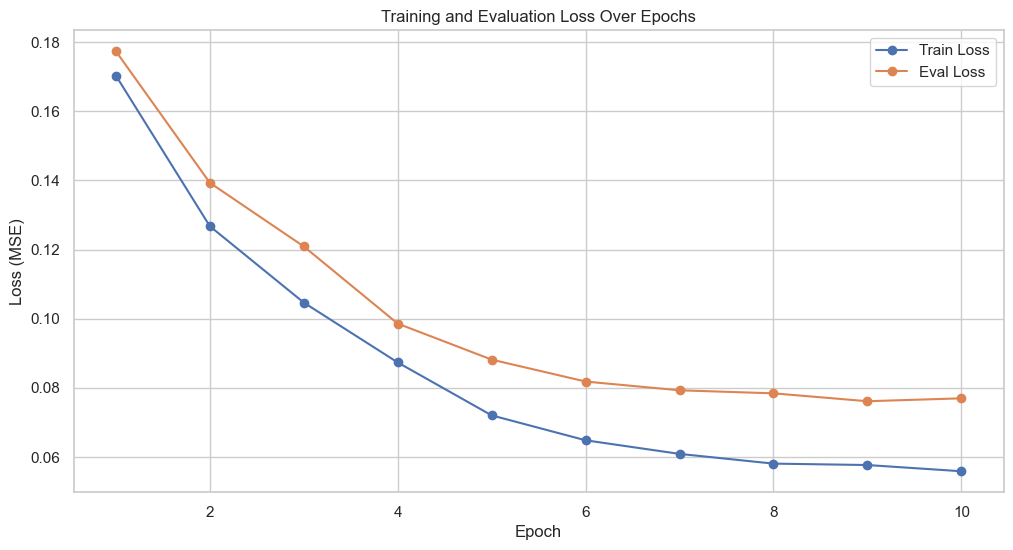

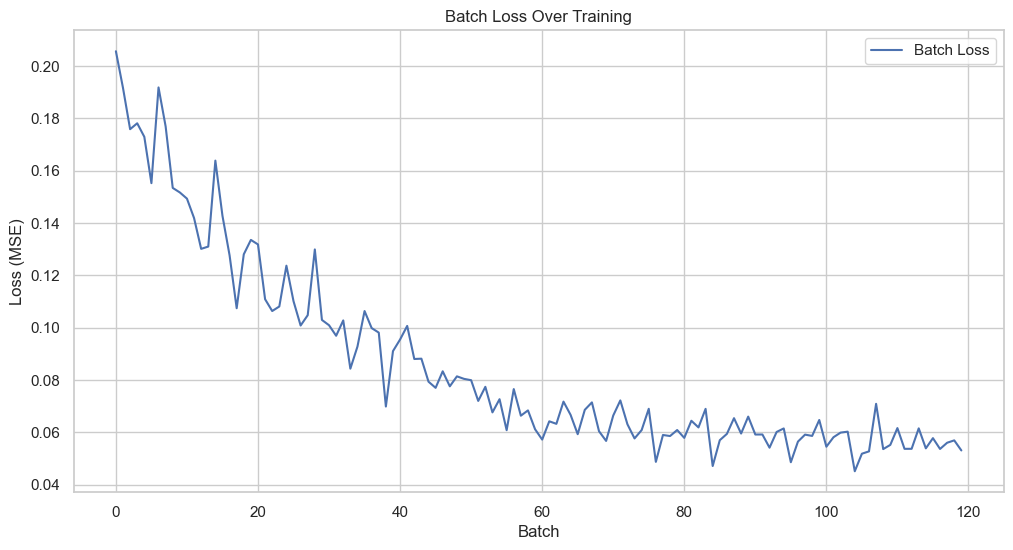

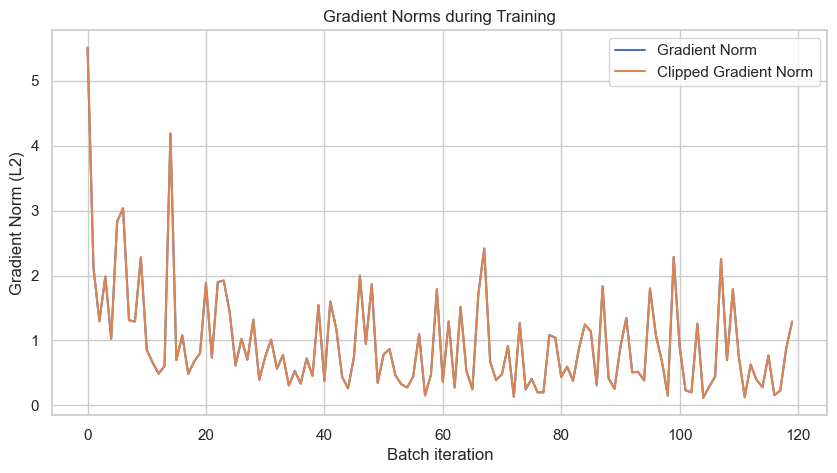

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'GRU'} -> Final Eval Loss: 0.0769
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'LSTM'}
Using device: mps
Epoch [1/10], Train Loss: 0.4436, Eval Loss: 0.2541
Epoch [2/10], Train Loss: 0.1346, Eval Loss: 0.1164
Epoch [3/10], Train Loss: 0.0844, Eval Loss: 0.1027
Epoch [4/10], Train Loss: 0.0766, Eval Loss: 0.0955
Epoch [5/10], Train Loss: 0.0685, Eval Loss: 0.0943
Epoch [6/10], Train Loss: 0.0661, Eval Loss: 0.0922
Epoch [7/10], Train Loss: 0.0641, Eval Loss: 0.0906
Epoch [8/10], Train Loss: 0.0628, Eval Loss: 0.0898
Epoch [9/10], Train Loss: 0.0626, Eval Loss: 0.0893
Epoch [10/10], Train Loss: 0.0614, Eval Loss: 0.0888


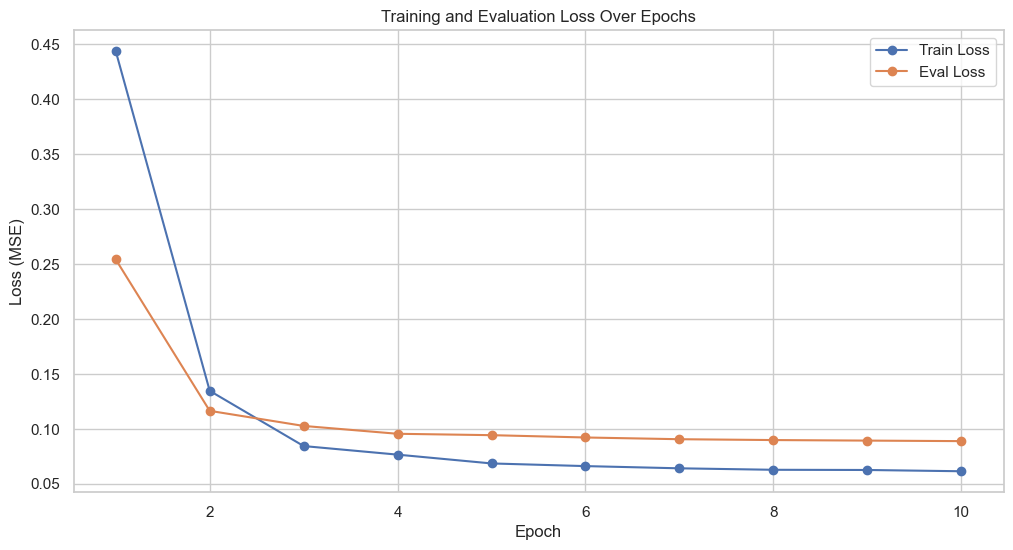

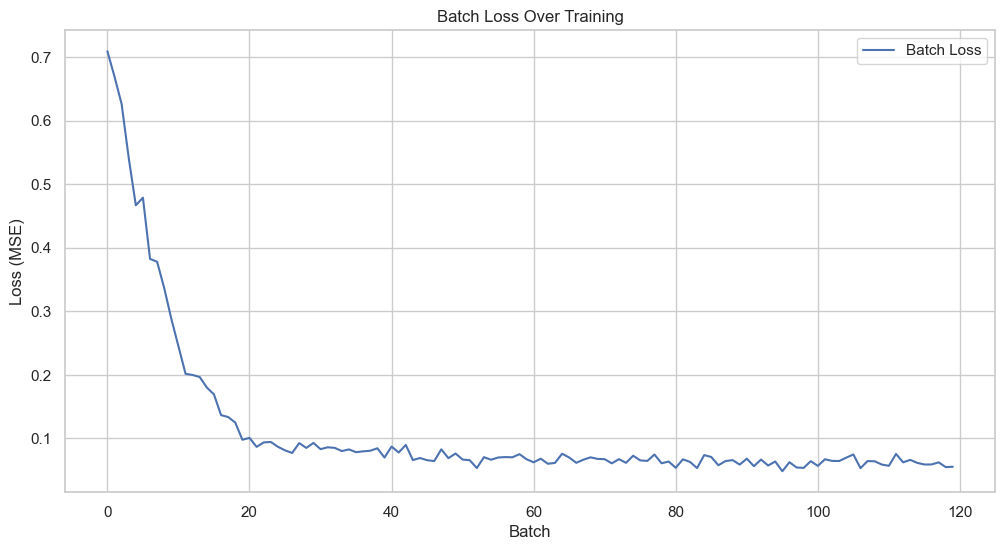

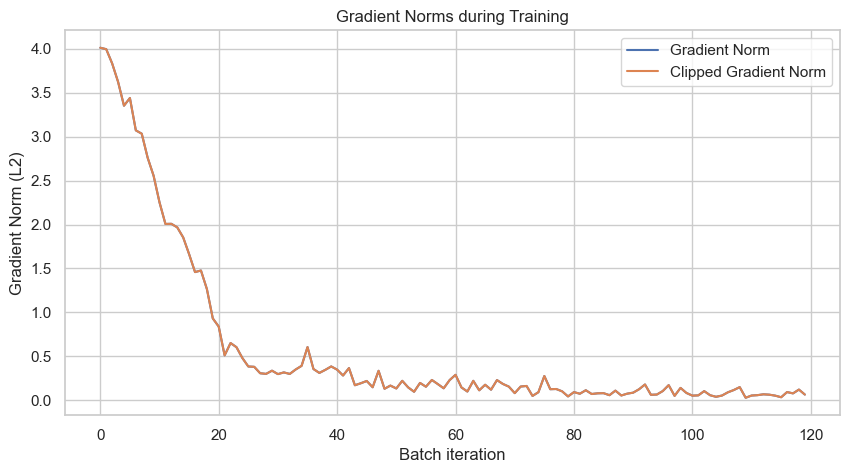

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'LSTM'} -> Final Eval Loss: 0.0888
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'RNN'}
Using device: mps
Epoch [1/10], Train Loss: 0.0982, Eval Loss: 0.1102
Epoch [2/10], Train Loss: 0.0765, Eval Loss: 0.1065
Epoch [3/10], Train Loss: 0.0714, Eval Loss: 0.0971
Epoch [4/10], Train Loss: 0.0673, Eval Loss: 0.0930
Epoch [5/10], Train Loss: 0.0649, Eval Loss: 0.0908
Epoch [6/10], Train Loss: 0.0635, Eval Loss: 0.0889
Epoch [7/10], Train Loss: 0.0625, Eval Loss: 0.0870
Epoch [8/10], Train Loss: 0.0611, Eval Loss: 0.0855
Epoch [9/10], Train Loss: 0.0604, Eval Loss: 0.0847
Epoch [10/10], Train Loss: 0.0591, Eval Loss: 0.0852


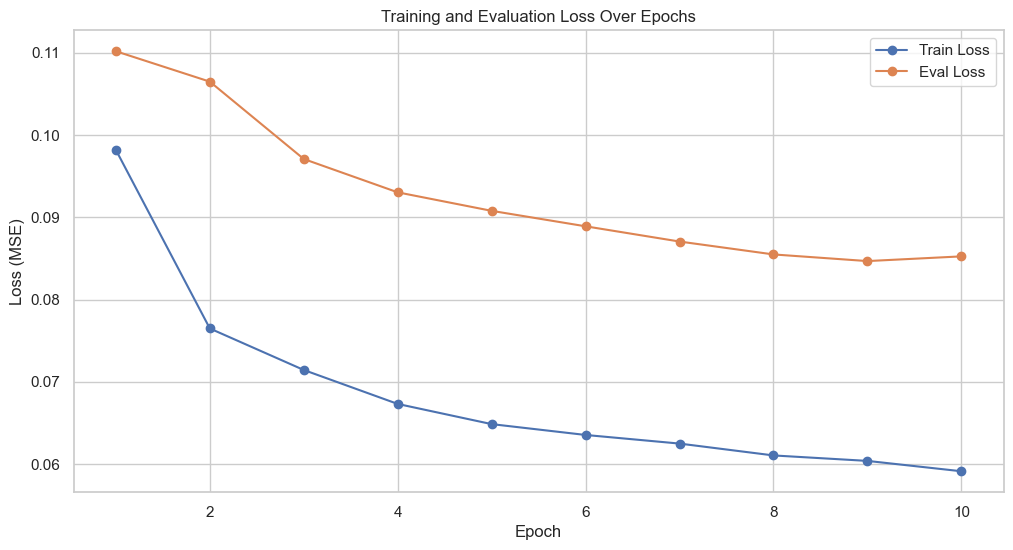

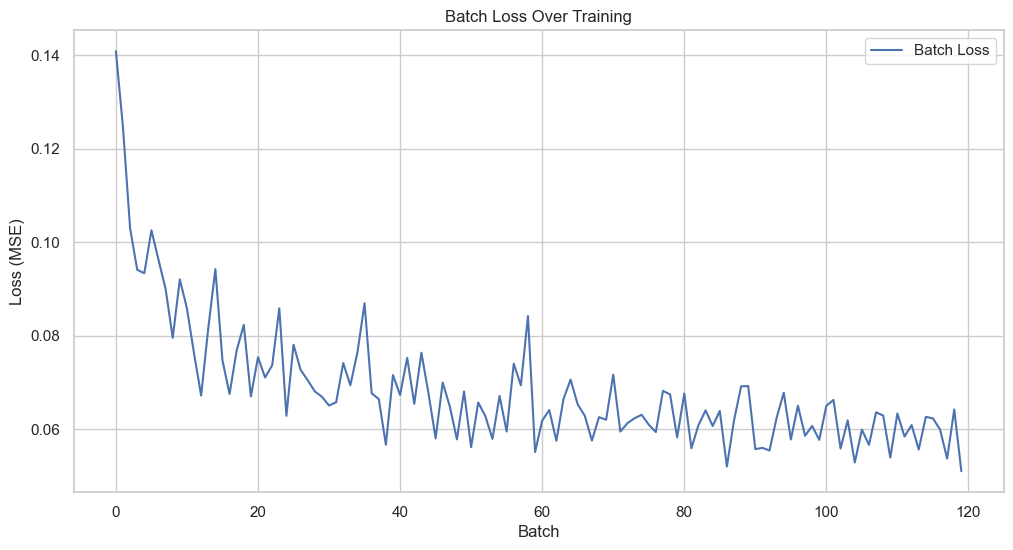

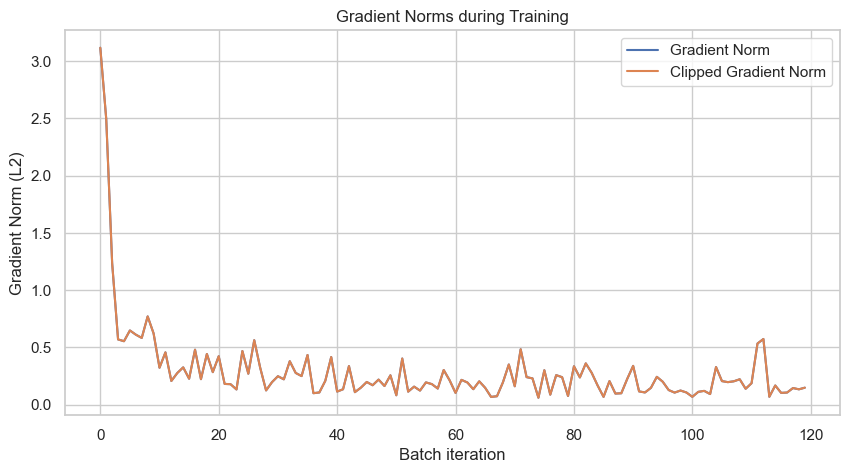

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'RNN'} -> Final Eval Loss: 0.0852
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'GRU'}
Using device: mps
Epoch [1/10], Train Loss: 0.6923, Eval Loss: 0.3472
Epoch [2/10], Train Loss: 0.2625, Eval Loss: 0.2352
Epoch [3/10], Train Loss: 0.1774, Eval Loss: 0.1826
Epoch [4/10], Train Loss: 0.1537, Eval Loss: 0.1624
Epoch [5/10], Train Loss: 0.1299, Eval Loss: 0.1344
Epoch [6/10], Train Loss: 0.1200, Eval Loss: 0.1322
Epoch [7/10], Train Loss: 0.1070, Eval Loss: 0.1215
Epoch [8/10], Train Loss: 0.0986, Eval Loss: 0.1214
Epoch [9/10], Train Loss: 0.0933, Eval Loss: 0.1118
Epoch [10/10], Train Loss: 0.0897, Eval Loss: 0.1047


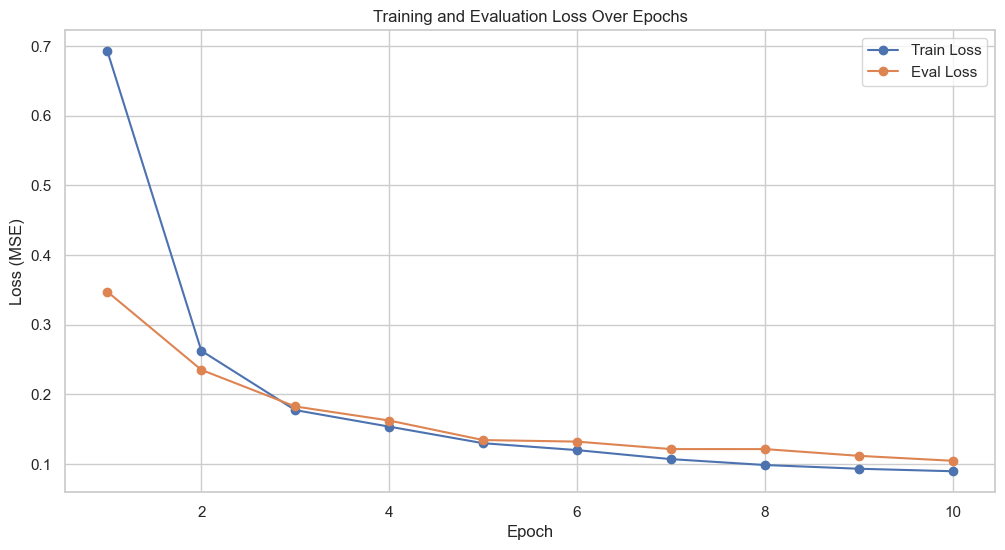

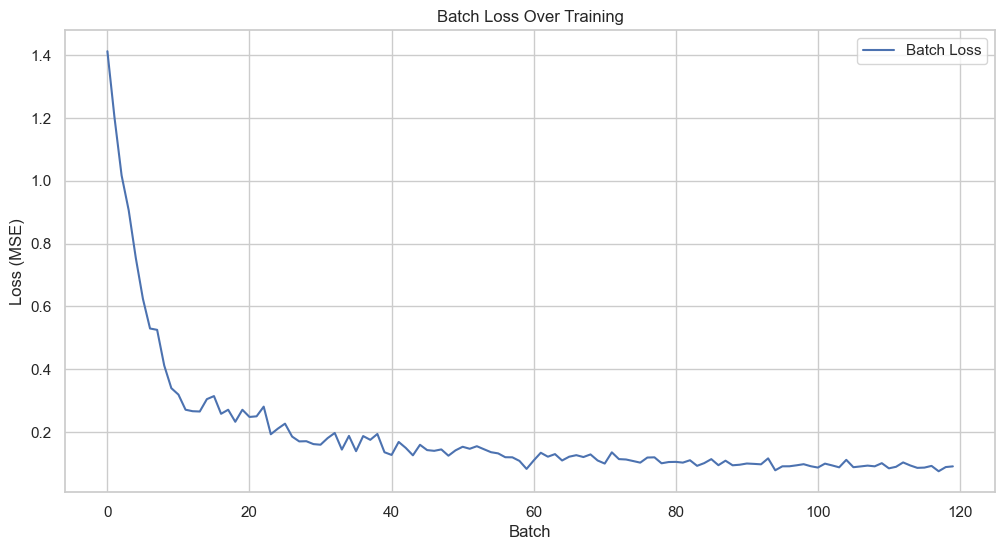

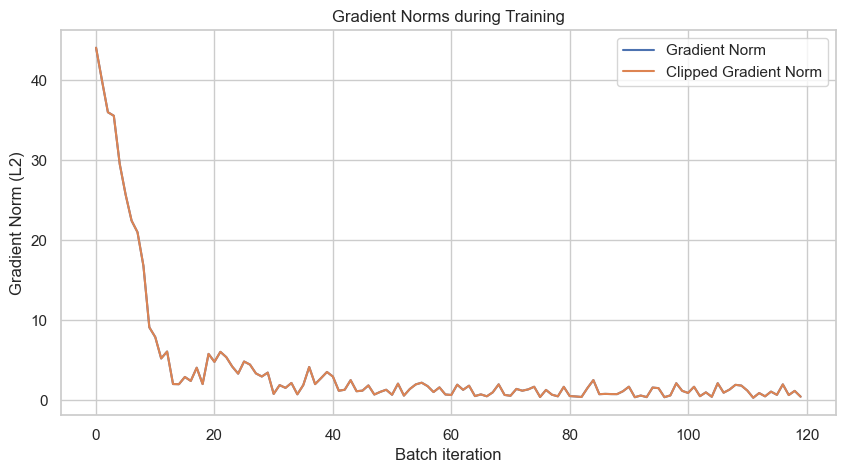

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'GRU'} -> Final Eval Loss: 0.1047
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'LSTM'}
Using device: mps
Epoch [1/10], Train Loss: 0.7923, Eval Loss: 0.5982
Epoch [2/10], Train Loss: 0.4348, Eval Loss: 0.3643
Epoch [3/10], Train Loss: 0.2591, Eval Loss: 0.2352
Epoch [4/10], Train Loss: 0.1534, Eval Loss: 0.1441
Epoch [5/10], Train Loss: 0.0986, Eval Loss: 0.1060
Epoch [6/10], Train Loss: 0.0789, Eval Loss: 0.0934
Epoch [7/10], Train Loss: 0.0700, Eval Loss: 0.0878
Epoch [8/10], Train Loss: 0.0648, Eval Loss: 0.0851
Epoch [9/10], Train Loss: 0.0622, Eval Loss: 0.0831
Epoch [10/10], Train Loss: 0.0611, Eval Loss: 0.0822


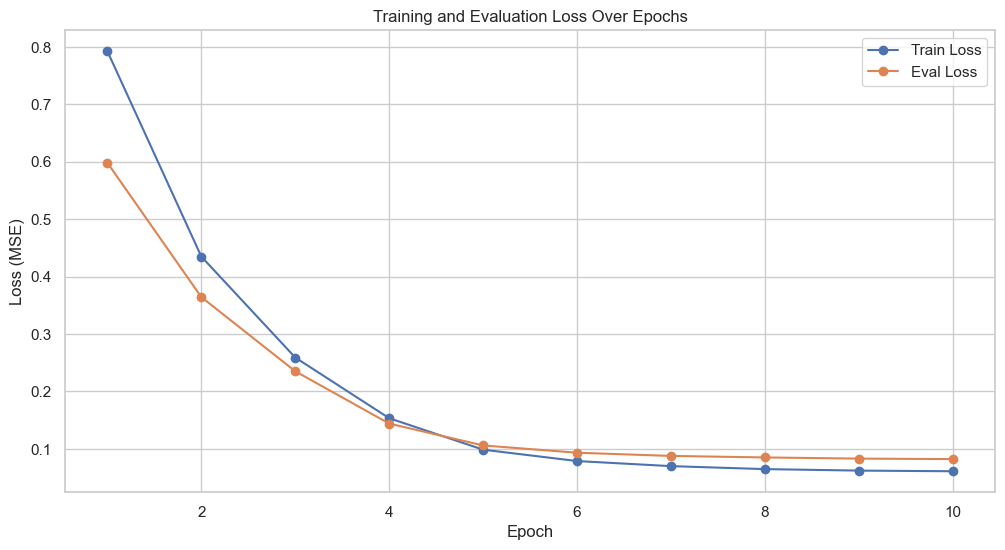

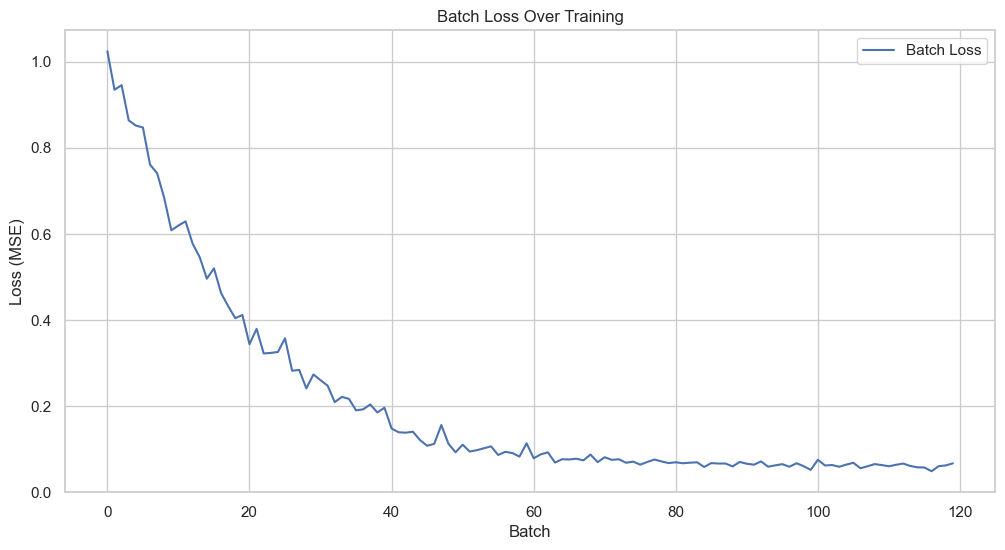

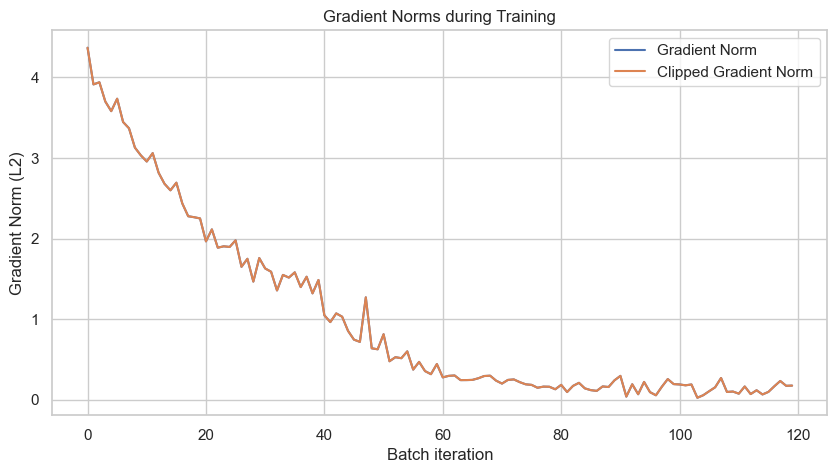

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'LSTM'} -> Final Eval Loss: 0.0822
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'RNN'}
Using device: mps
Epoch [1/10], Train Loss: 0.1073, Eval Loss: 0.1077
Epoch [2/10], Train Loss: 0.0750, Eval Loss: 0.0968
Epoch [3/10], Train Loss: 0.0683, Eval Loss: 0.0939
Epoch [4/10], Train Loss: 0.0642, Eval Loss: 0.0917
Epoch [5/10], Train Loss: 0.0625, Eval Loss: 0.0904
Epoch [6/10], Train Loss: 0.0615, Eval Loss: 0.0900
Epoch [7/10], Train Loss: 0.0609, Eval Loss: 0.0897
Epoch [8/10], Train Loss: 0.0611, Eval Loss: 0.0896
Epoch [9/10], Train Loss: 0.0602, Eval Loss: 0.0892
Epoch [10/10], Train Loss: 0.0592, Eval Loss: 0.0888


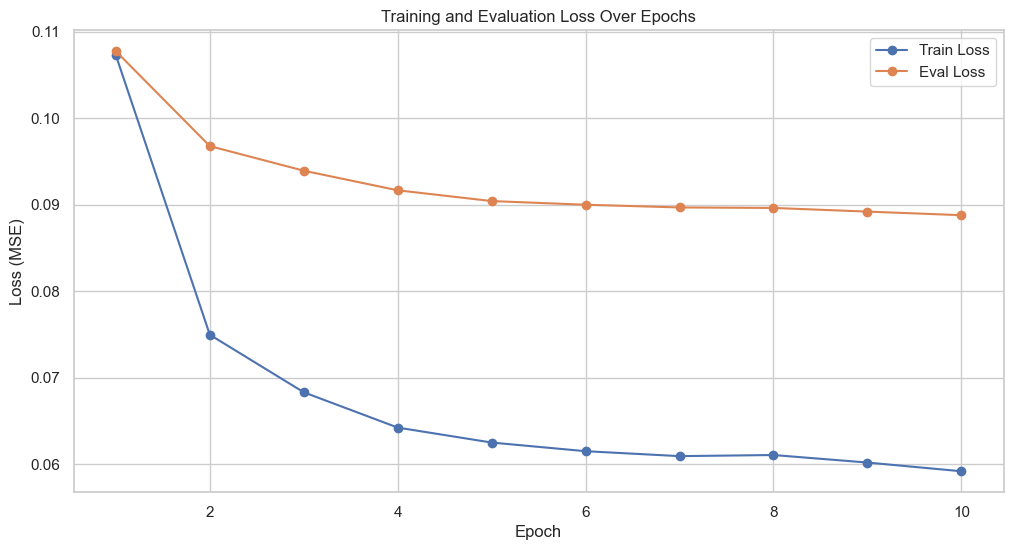

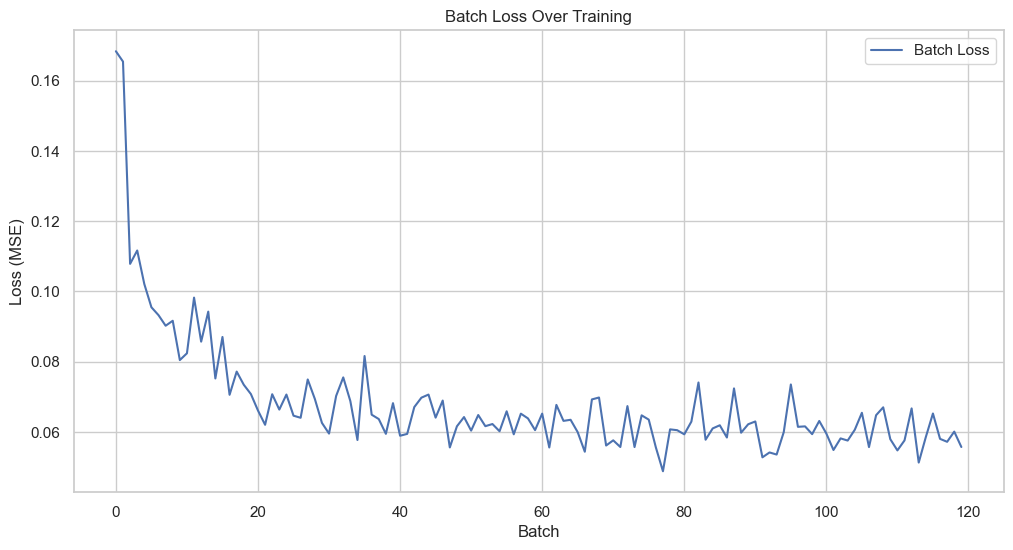

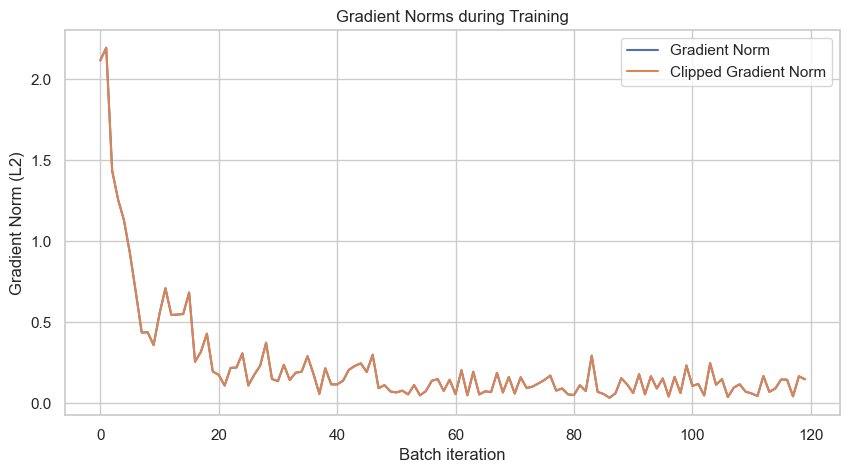

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'RNN'} -> Final Eval Loss: 0.0888
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'GRU'}
Using device: mps
Epoch [1/10], Train Loss: 0.6555, Eval Loss: 0.2695
Epoch [2/10], Train Loss: 0.2282, Eval Loss: 0.1819
Epoch [3/10], Train Loss: 0.1278, Eval Loss: 0.1507
Epoch [4/10], Train Loss: 0.1124, Eval Loss: 0.1251
Epoch [5/10], Train Loss: 0.0994, Eval Loss: 0.1220
Epoch [6/10], Train Loss: 0.0939, Eval Loss: 0.1207
Epoch [7/10], Train Loss: 0.0905, Eval Loss: 0.1172
Epoch [8/10], Train Loss: 0.0865, Eval Loss: 0.1153
Epoch [9/10], Train Loss: 0.0838, Eval Loss: 0.1126
Epoch [10/10], Train Loss: 0.0802, Eval Loss: 0.1082


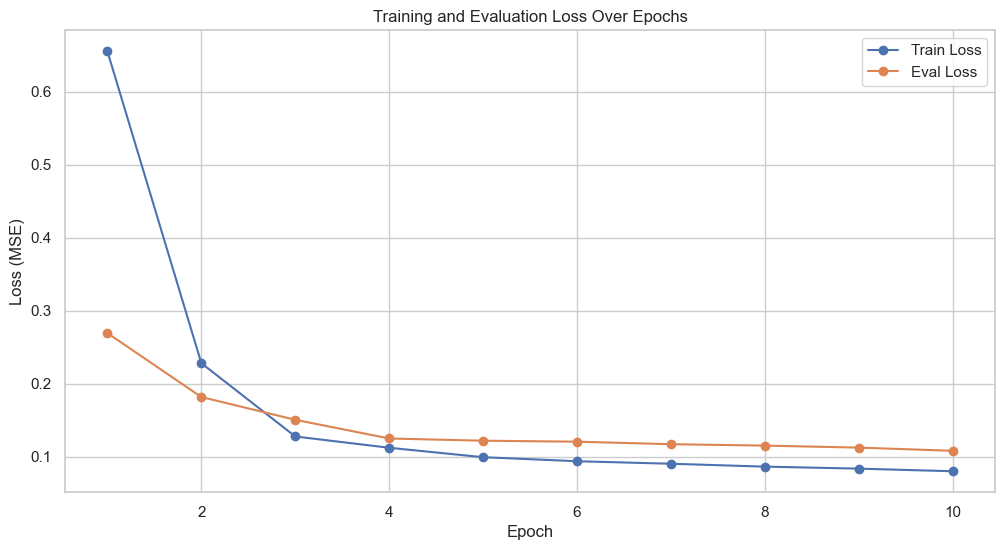

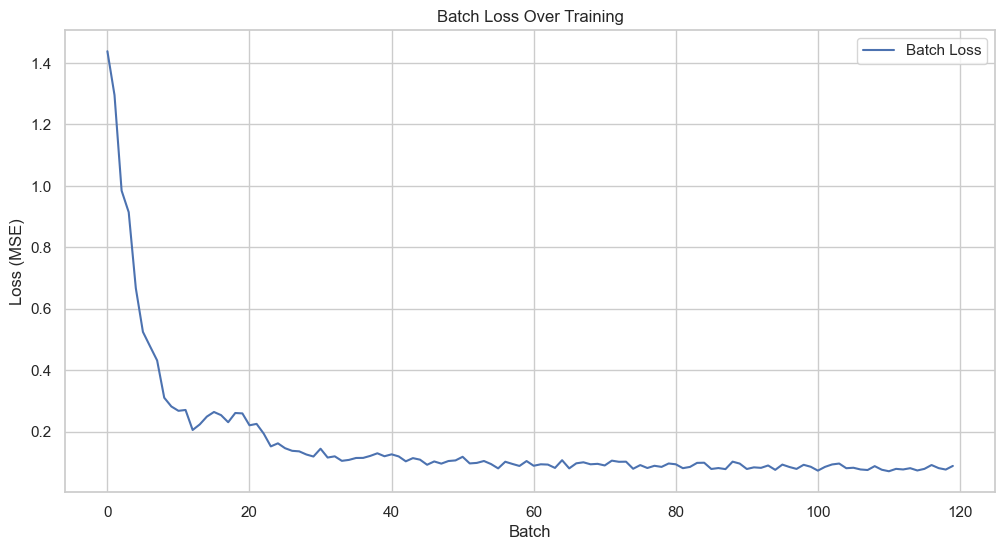

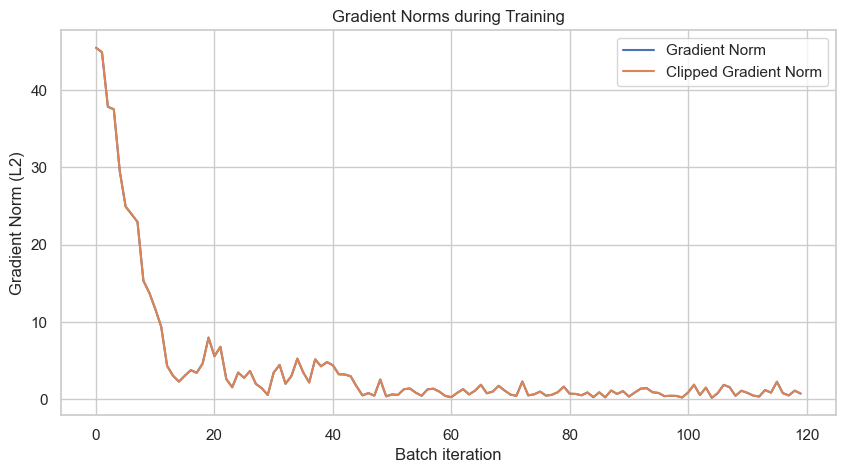

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'GRU'} -> Final Eval Loss: 0.1082
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'LSTM'}
Using device: mps
Epoch [1/10], Train Loss: 0.4374, Eval Loss: 0.2662
Epoch [2/10], Train Loss: 0.1693, Eval Loss: 0.1723
Epoch [3/10], Train Loss: 0.0907, Eval Loss: 0.1124
Epoch [4/10], Train Loss: 0.0698, Eval Loss: 0.1081
Epoch [5/10], Train Loss: 0.0676, Eval Loss: 0.1098
Epoch [6/10], Train Loss: 0.0635, Eval Loss: 0.1097
Epoch [7/10], Train Loss: 0.0634, Eval Loss: 0.1067
Epoch [8/10], Train Loss: 0.0625, Eval Loss: 0.1067
Epoch [9/10], Train Loss: 0.0618, Eval Loss: 0.1065
Epoch [10/10], Train Loss: 0.0614, Eval Loss: 0.1051


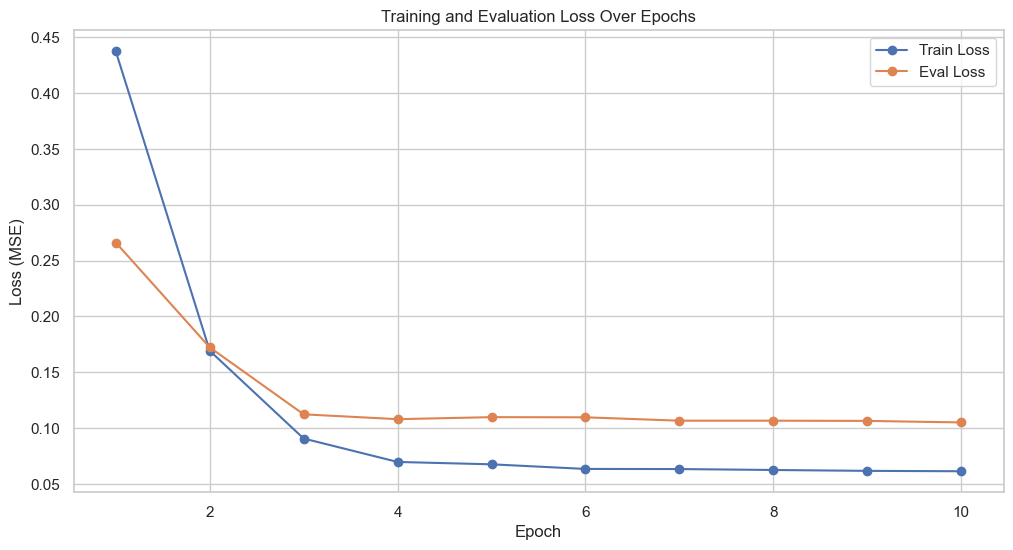

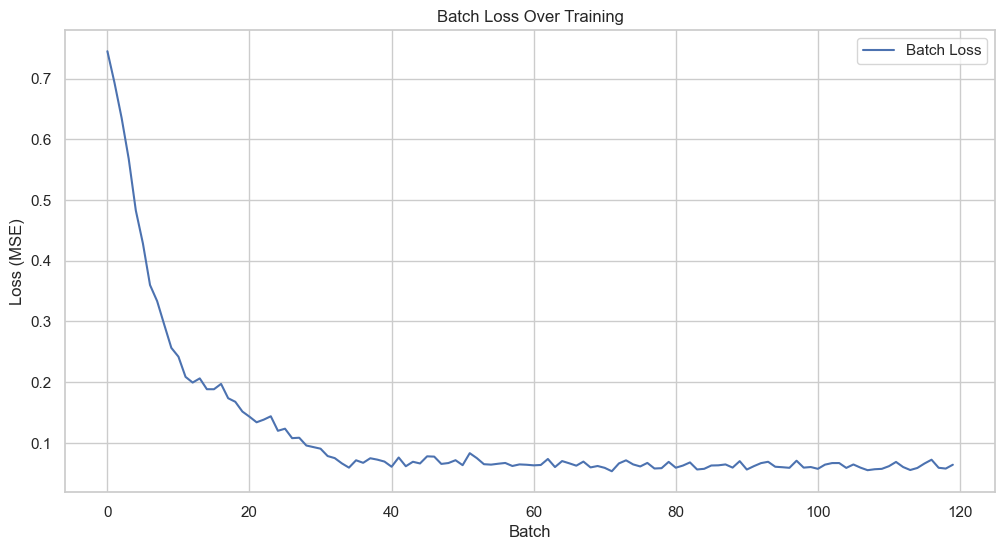

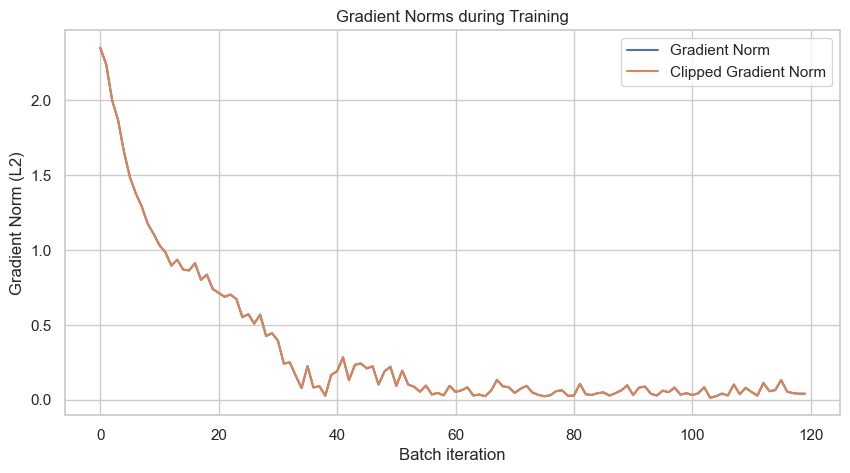

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'LSTM'} -> Final Eval Loss: 0.1051
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'RNN'}
Using device: mps
Epoch [1/10], Train Loss: 0.4436, Eval Loss: 0.1046
Epoch [2/10], Train Loss: 0.0912, Eval Loss: 0.1424
Epoch [3/10], Train Loss: 0.0856, Eval Loss: 0.0984
Epoch [4/10], Train Loss: 0.0726, Eval Loss: 0.0959
Epoch [5/10], Train Loss: 0.0698, Eval Loss: 0.0948
Epoch [6/10], Train Loss: 0.0707, Eval Loss: 0.0935
Epoch [7/10], Train Loss: 0.0684, Eval Loss: 0.0920
Epoch [8/10], Train Loss: 0.0675, Eval Loss: 0.0916
Epoch [9/10], Train Loss: 0.0672, Eval Loss: 0.0915
Epoch [10/10], Train Loss: 0.0666, Eval Loss: 0.0905


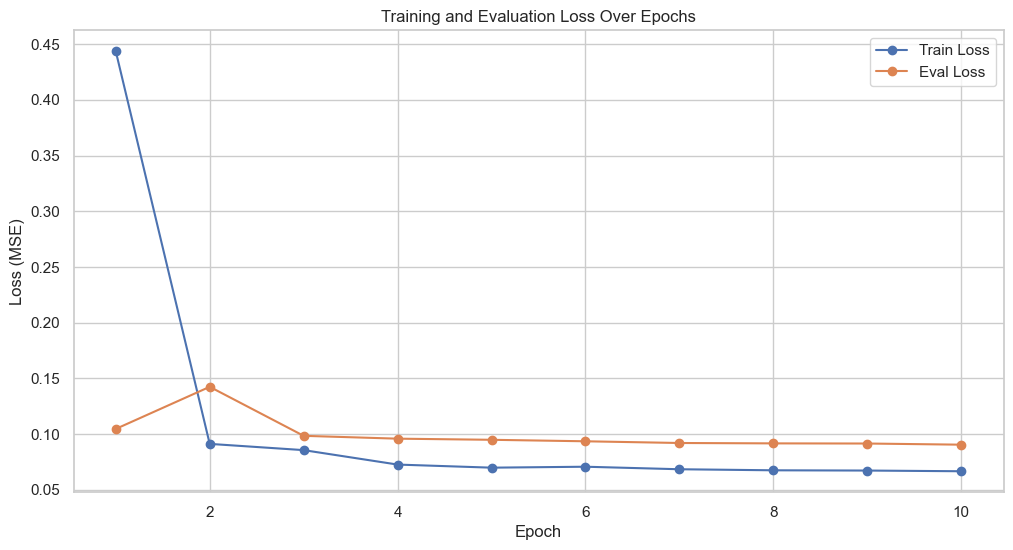

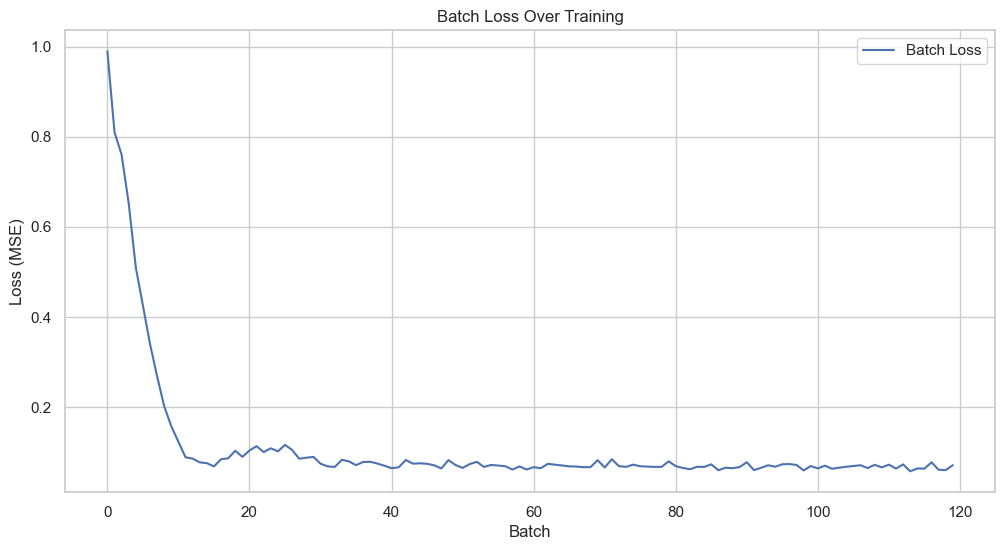

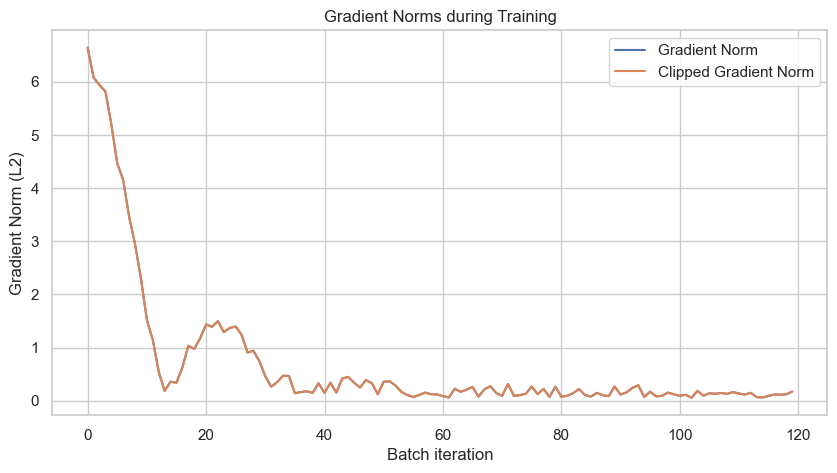

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'RNN'} -> Final Eval Loss: 0.0905
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'GRU'}
Using device: mps
Epoch [1/10], Train Loss: 1.3016, Eval Loss: 0.9698
Epoch [2/10], Train Loss: 0.6887, Eval Loss: 0.6707
Epoch [3/10], Train Loss: 0.4510, Eval Loss: 0.4353
Epoch [4/10], Train Loss: 0.2779, Eval Loss: 0.3043
Epoch [5/10], Train Loss: 0.1795, Eval Loss: 0.1979
Epoch [6/10], Train Loss: 0.1383, Eval Loss: 0.1605
Epoch [7/10], Train Loss: 0.1255, Eval Loss: 0.1430
Epoch [8/10], Train Loss: 0.1073, Eval Loss: 0.1202
Epoch [9/10], Train Loss: 0.0999, Eval Loss: 0.1238
Epoch [10/10], Train Loss: 0.0915, Eval Loss: 0.1139


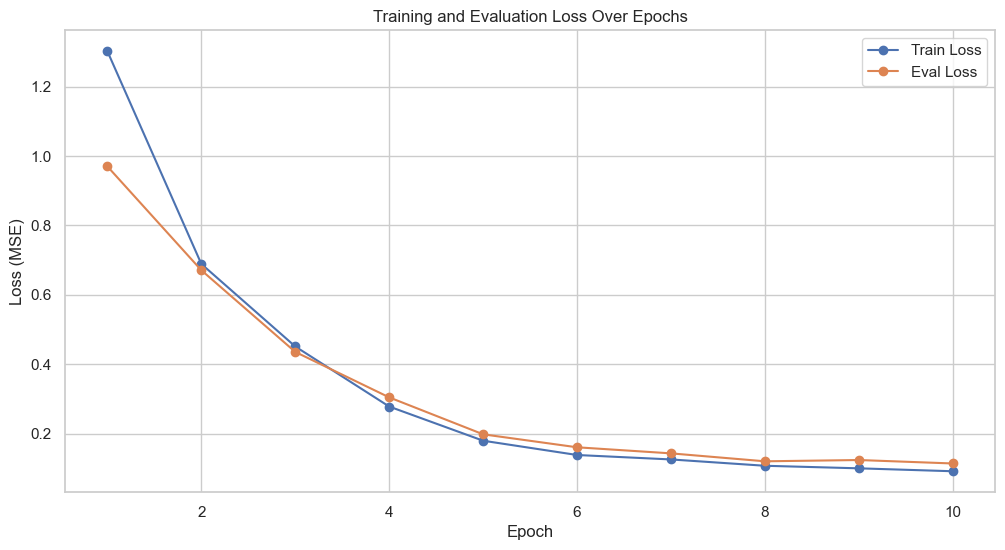

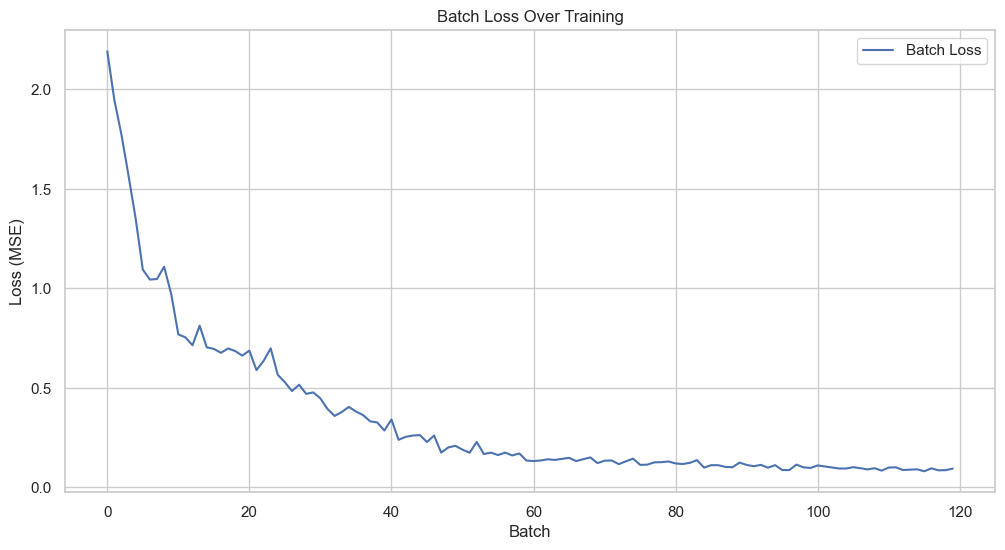

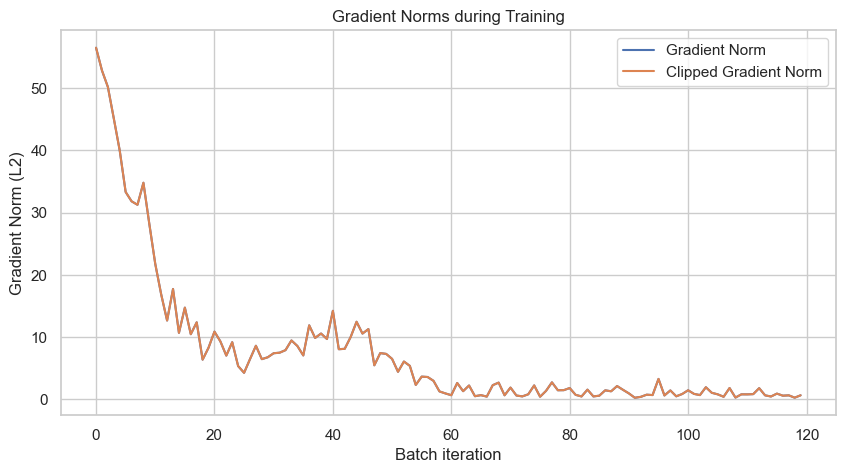

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'GRU'} -> Final Eval Loss: 0.1139
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'LSTM'}
Using device: mps
Epoch [1/10], Train Loss: 0.3383, Eval Loss: 0.2504
Epoch [2/10], Train Loss: 0.1167, Eval Loss: 0.1300
Epoch [3/10], Train Loss: 0.0742, Eval Loss: 0.1124
Epoch [4/10], Train Loss: 0.0674, Eval Loss: 0.1079
Epoch [5/10], Train Loss: 0.0642, Eval Loss: 0.1046
Epoch [6/10], Train Loss: 0.0633, Eval Loss: 0.1002
Epoch [7/10], Train Loss: 0.0624, Eval Loss: 0.0989
Epoch [8/10], Train Loss: 0.0619, Eval Loss: 0.0987
Epoch [9/10], Train Loss: 0.0632, Eval Loss: 0.0974
Epoch [10/10], Train Loss: 0.0623, Eval Loss: 0.0967


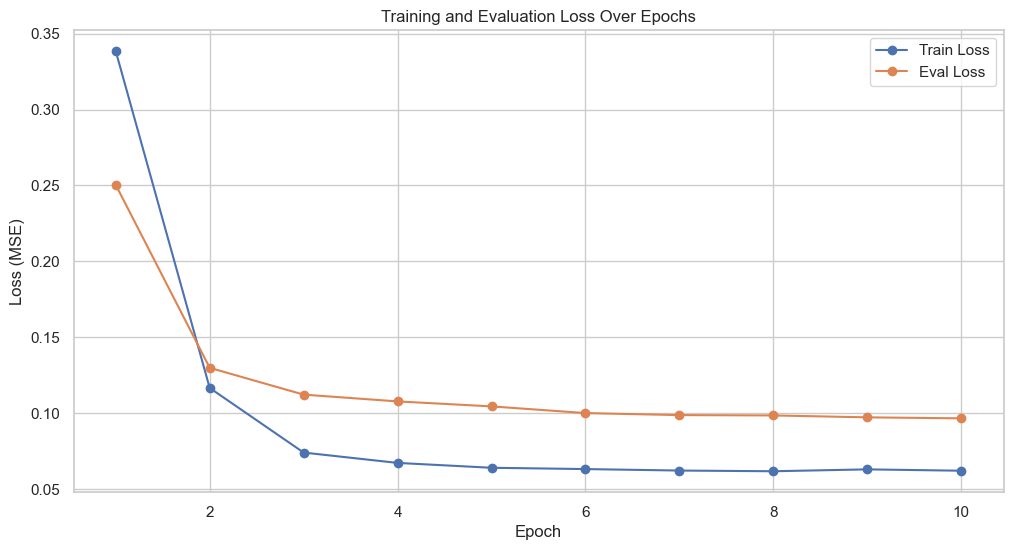

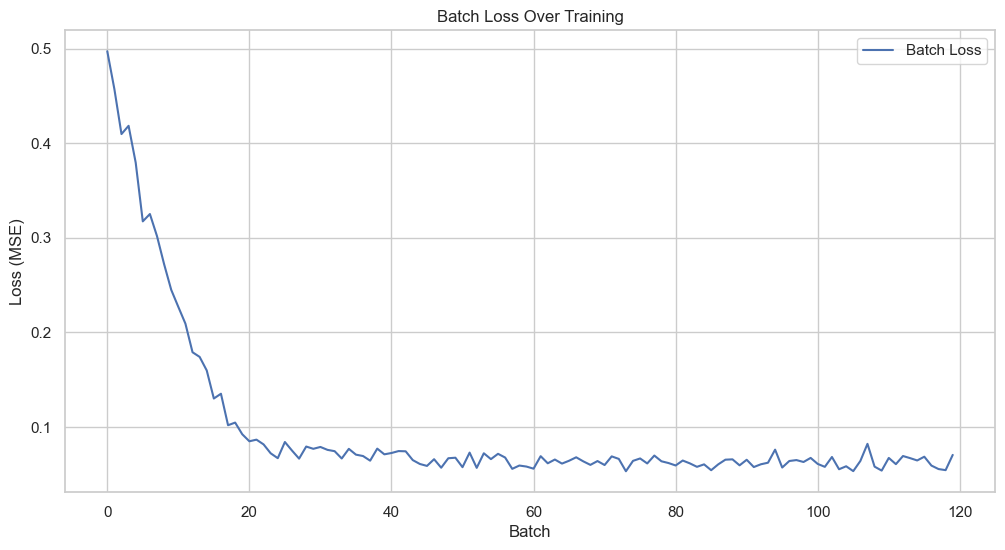

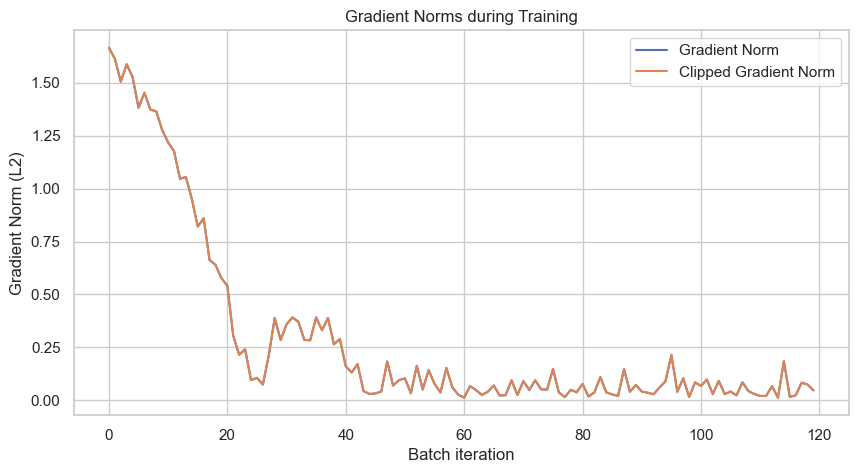

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'LSTM'} -> Final Eval Loss: 0.0967
Training with config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'RNN'}
Using device: mps
Epoch [1/10], Train Loss: 0.0909, Eval Loss: 0.0951
Epoch [2/10], Train Loss: 0.0738, Eval Loss: 0.0892
Epoch [3/10], Train Loss: 0.0691, Eval Loss: 0.0891
Epoch [4/10], Train Loss: 0.0699, Eval Loss: 0.0884
Epoch [5/10], Train Loss: 0.0665, Eval Loss: 0.0882
Epoch [6/10], Train Loss: 0.0617, Eval Loss: 0.0890
Epoch [7/10], Train Loss: 0.0622, Eval Loss: 0.0871
Epoch [8/10], Train Loss: 0.0622, Eval Loss: 0.0876
Epoch [9/10], Train Loss: 0.0605, Eval Loss: 0.0872
Epoch [10/10], Train Loss: 0.0604, Eval Loss: 0.0861


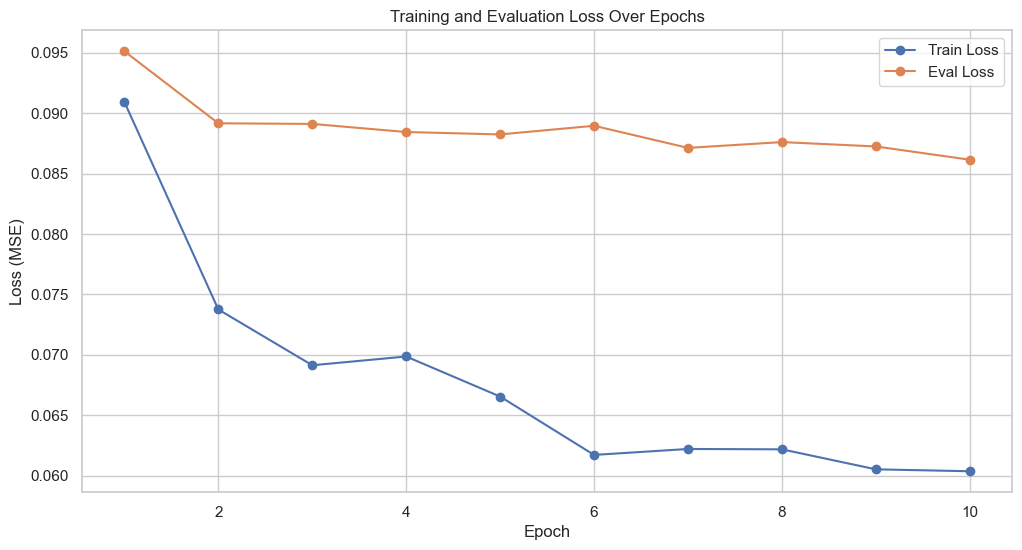

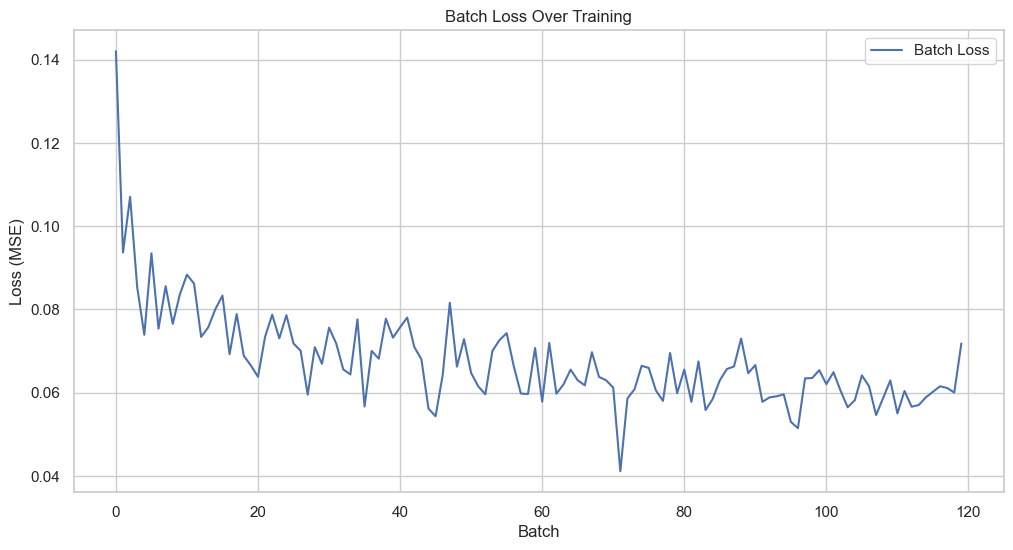

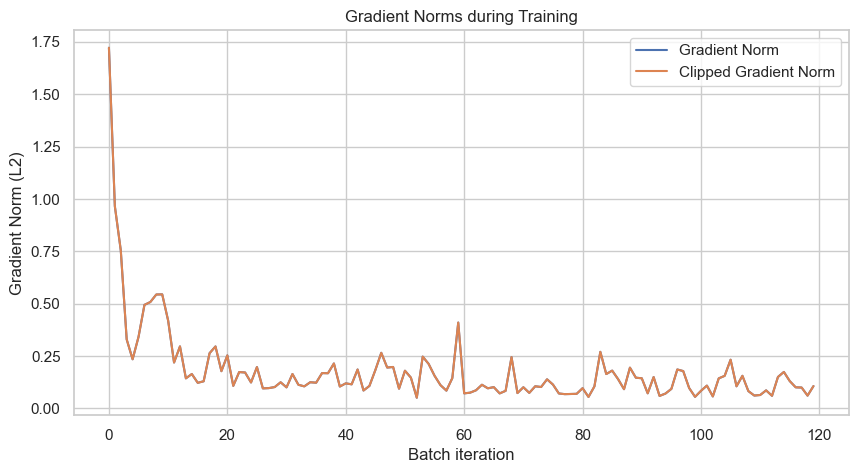

Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.2, 'model': 'RNN'} -> Final Eval Loss: 0.0861

Grid Search Complete!
Best Config: {'input_dim': 98, 'hidden_dim': 16, 'num_layers': 1, 'output_dim': 1, 'num_epochs': 10, 'learning_rate': 0.001, 'dropout': 0.1, 'model': 'GRU'}
Best Final Eval Loss: 0.0769


In [220]:
def grid_search(train_loader, test_loader, train_dataset, output_dim, num_epochs):
    """
    Performs grid search over specified hyperparameters including model type.
    
    Parameters:
        train_loader : DataLoader for training data.
        test_loader  : DataLoader for test/validation data.
        train_dataset: Dataset used for training (to obtain input_dim).
        output_dim   : Output dimension for the model.
        num_epochs   : Number of epochs to train.
    
    Returns:
        best_config: Dictionary with the best hyperparameters.
        best_eval_loss: Final evaluation loss from the best config.
        results: List with tuples (config, final_eval_loss) for each run.
    """
    
    # Define search grid for hyperparameters including the model type.
    grid = {
        "hidden_dim": [16],
        "num_layers": [1, 2],
        "dropout": [0.1, 0.2],
        "learning_rate": [0.001],
        "model": ["GRU", "LSTM", "RNN"]
    }

    
    best_config = None
    best_eval_loss = float('inf')
    results = []
    
    # Iterate over every combination of hyperparameters.
    for hidden_dim in grid["hidden_dim"]:
        for num_layers in grid["num_layers"]:
            for dropout in grid["dropout"]:
                for learning_rate in grid["learning_rate"]:
                    for model_type in grid["model"]:
                        # Set up the configuration dictionary for the current combination.
                        config = {
                            "input_dim": len(train_dataset.features),
                            "hidden_dim": hidden_dim,
                            "num_layers": num_layers,
                            "output_dim": output_dim,
                            "num_epochs": num_epochs,
                            "learning_rate": learning_rate,
                            "dropout": dropout,
                            "model": model_type,
                        }
                        
                        print(f"Training with config: {config}")
                        
                        # Call the train function which returns the training and evaluation metrics.
                        (model, train_epoch_losses, eval_epoch_losses,
                         batch_losses, grad_norms, clipped_grad_norms) = train(config, train_loader, test_loader)
                        
                        # Use the final evaluation loss as the metric for grid search.
                        final_eval_loss = eval_epoch_losses[-1]
                        results.append((config, final_eval_loss))
                        
                        print(f"Config: {config} -> Final Eval Loss: {final_eval_loss:.4f}")
                        
                        # Update the best configuration if current one improves evaluation loss.
                        if final_eval_loss < best_eval_loss:
                            best_eval_loss = final_eval_loss
                            best_config = config
    
    print("\nGrid Search Complete!")
    print(f"Best Config: {best_config}")
    print(f"Best Final Eval Loss: {best_eval_loss:.4f}")
    return best_config, best_eval_loss, results

best_config, best_loss, all_results = grid_search(train_loader, test_loader, train_dataset, 1, 10)